In [1]:
import os
import numpy as np
import pickle

import torch
import torch.nn as nn
from torch.autograd import Variable

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
class simple_bidirectional_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bidirectional):
        super(simple_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=bidirectional)
        if output_size != 0:
            self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_x, hidden):
        output, hidden = self.lstm(input_x, hidden)
        if self.output_size != 0:
            output = self.fc(output)
        return output, hidden
    
    def initHidden(self):
        if self.bidirectional:
            result = Variable(torch.zeros(2, 1, self.hidden_size))
        else:
            result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda()

In [3]:
class simple_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(simple_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        if output_size != 0:
            self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_x, hidden):
        output, hidden = self.lstm(input_x, hidden)
        if self.output_size != 0:
            output = self.fc(output)
        return output, hidden
    
    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda()

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
########## Load RGB Player Features and Dictionaries ############
player_feature_path = './consistent_players/player_feature_spatial'
player_corr_path = './consistent_players/corr'
game_ids = ['1365-1', '1382-1', '1382-2', '1382-3', '1395-1', '1395-2', '1395-3', '1403-2', '1403-3', '1497-2']
#game_ids = ['1365-1', '1382-1']
#game_ids = ['1365-1']

In [6]:
player_features = []
for game_id in game_ids:
    feature_file = os.path.join(player_feature_path, game_id+'.txt')
    tmp_features = np.genfromtxt(feature_file, delimiter = ' ', dtype = float)
    player_features.append(tmp_features)
player_features = np.vstack(player_features)

In [7]:
d_corr_player = {}
for game_id in game_ids:
    corr_file = os.path.join(player_corr_path, game_id+'.p')
    with open(corr_file, 'rb') as fp:
        d_corr_tmp = pickle.load(fp)
        d_corr_player.update(d_corr_tmp)

event_to_label = {'dumpin': 0, 'dumpout': 1, 'shot': 2, 'pass': 3, 'carry': 4, 'puckprotection': 5}
considered_events = event_to_label.keys()
all_events = d_corr_player.keys()
print 'total number of events: ' + str(len(all_events))

total number of events: 4257


In [8]:
total_num_events = len(all_events)
num_test = total_num_events // 5
num_train = total_num_events - num_test
train_events = all_events[:num_train]
val_events = all_events[num_train:]

In [9]:
###########  Load Event RGB Frame Features and Dictionaries ##########
rgb_frame_feature_path = './frames/features'
rgb_frame_corr_path = './frames/corr'
rgb_frame_features = []
for game_id in game_ids:
    feature_file = os.path.join(rgb_frame_feature_path, game_id+'.txt')
    tmp_features = np.genfromtxt(feature_file, delimiter=' ', dtype = float)
    rgb_frame_features.append(tmp_features)
rgb_frame_features = np.vstack(rgb_frame_features)

In [10]:
d_corr_rgb_frame = {}
for game_id in game_ids:
    corr_file = os.path.join(rgb_frame_corr_path, game_id+'.p')
    with open(corr_file, 'rb') as fp:
        d_corr_tmp = pickle.load(fp)
        d_corr_rgb_frame.update(d_corr_tmp)

In [11]:
team_id_lines = []
for game_id in game_ids:
    filename = './team_ids/team_id_' + game_id + '.txt'
    team_id_lines += [line.strip() for line in open(filename).readlines()]
d_teamid = {}
for line in team_id_lines:
    img_name = line.split(' ')[0]
    label = int(line.split(' ')[1])
    d_teamid[img_name] = label

In [12]:
########   Read in grid information and flipped information #######
d_coordinates = {}
d_grid = {}
coordinates_path = './coordinates/dic'
for game_id in game_ids:
    with open(os.path.join(coordinates_path, game_id+'.p'), 'rb') as fp:
        d = pickle.load(fp)
        d_coordinates.update(d)
    with open(os.path.join('./grid_info_less', game_id+'.p'), 'rb') as fp:
        d = pickle.load(fp)
        d_grid.update(d)
flipped_lines = [line.strip() for line in open('./coordinates/new_events_flipped.txt').readlines()]
d_flags = {}
for line in flipped_lines:
    flipped_event = line.split(',')[0]
    flipped_flag = line.split(',')[1][1:]
    d_flags[flipped_event] = flipped_flag
# Flip coordinates
events = d_coordinates.keys()
for event in events:
    event_flag = d_flags[event]
    if event_flag == 'True':
        frame_ids = d_coordinates[event].keys()
        for frame_id in frame_ids:
            players = d_coordinates[event][frame_id].keys()
            for player in players:
                coor = d_coordinates[event][frame_id][player]
                coor[0] = -coor[0]
                coor[1] = -coor[1]
    else:
        continue

In [13]:
frame_start_idx = 25
frame_end_idx = 27

In [14]:
def get_ap(labels, pred_scores, n_classes, feature, save_name):
    a = []
    for i in pred_scores:
        a += np.array(i.data)[0],
    a = np.array(a)
    b = []
    for i in labels:
        b += i[0],
    b = np.array(b)
    b_binary = label_binarize(b, [0, 1, 2, 3, 4, 5])
    Y_test = b_binary
    y_score = a
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        #print Y_test[:, i]
        #print y_score[:, i]
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                         average="micro")
    plt.figure()
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score using ' + feature + ' features: AP={0:0.4f}'
        .format(average_precision["micro"]))
    #plt.savefig('ap_new/' + save_name)
    return average_precision['micro']

In [15]:
def step(event_line, criterion, player_lstm, rgb_frame_lstm, coordinate_lstm, event_lstm, 
         coordinate_linear_layer_1, coordinate_linear_layer_2,
         hidden_dim_player, hidden_dim_player_coordinate, hidden_dim_frame, hidden_dim_event, num_classes):
    
    d_frame = d_corr_rgb_frame[event_line]
    event_name = event_line.split('_')[1]
    label = np.array([event_to_label[event_name]])
    label = Variable(torch.LongTensor(label)).cuda()
    
    players = d_corr_player[event_line]['frame'+str('%06d'%frame_start_idx)].keys()
    num_players = len(players)
    
    d_player_hidden_features = {}
    d_player_hidden_features['frame'+str('%06d'%(frame_start_idx-1))] = {}
    d_player_coordinate_hidden_features = {}
    d_player_coordinate_hidden_features['frame'+str('%06d'%(frame_start_idx-1))] = {}
    for player in players:
        d_player_hidden_features['frame'+str('%06d'%(frame_start_idx-1))][player] = (player_lstm.initHidden(), player_lstm.initHidden())
        d_player_coordinate_hidden_features['frame'+str('%06d'%(frame_start_idx-1))][player] = (coordinate_lstm.initHidden(), coordinate_lstm.initHidden())
        
    
    for frame_idx in range(frame_start_idx, frame_end_idx+1):
        
        # Event lstm hidden state
        if frame_idx == frame_start_idx:
            event_hidden = (event_lstm.initHidden(), event_lstm.initHidden())
        
        # Load rgb frame feature and pass through lstm
        rgb_frame_line_idx = d_frame['frame'+str('%06d'%frame_idx)]
        rgb_frame_feature = rgb_frame_features[rgb_frame_line_idx]
        rgb_frame_feature = Variable(torch.FloatTensor(rgb_frame_feature)).cuda()
        
        if frame_idx == frame_start_idx:
            rgb_frame_hidden = (rgb_frame_lstm.initHidden(), rgb_frame_lstm.initHidden())
        rgb_frame_feature = rgb_frame_feature.view(1, 1, 2048)
        output, rgb_frame_hidden = rgb_frame_lstm(rgb_frame_feature, rgb_frame_hidden)
        
        # Load player features and pass through lstm
        d_player_hidden_features['frame'+str('%06d'%frame_idx)] = {}
        for player in players:
            player_line_idx = d_corr_player[event_line]['frame'+str('%06d'%frame_idx)][player]
            player_feature = player_features[player_line_idx]
            player_feature = Variable(torch.FloatTensor(player_feature)).cuda()
            player_feature = player_feature.view(1, 1, 2048)
            
            player_hidden = d_player_hidden_features['frame'+str('%06d'%(frame_idx-1))][player]
            output, player_hidden = player_lstm.forward(player_feature, player_hidden)
            d_player_hidden_features['frame'+str('%06d'%frame_idx)][player] = player_hidden
            
        # Load player coordinates & grid and pass through lstm
        d_player_coordinate_hidden_features['frame'+str('%06d'%frame_idx)] = {}
        for player in players:
            player_coordinate = np.array(d_coordinates[event_line]['frame'+str('%06d'%frame_idx)][player])
            player_coordinate = Variable(torch.FloatTensor(player_coordinate)).cuda()
            coordinate_linear_output_1 = coordinate_linear_layer_1(player_coordinate)
            coordinate_linear_output_1 = coordinate_linear_output_1.view(1, 1, hidden_dim_player_coordinate//2)
            
            player_grid = d_grid[event_line]['frame'+str('%06d'%frame_idx)][player]
            coordinate_linear_input_2 = torch.zeros((1, 1, hidden_dim_player_coordinate))
            coordinate_linear_input_2 = Variable(torch.FloatTensor(coordinate_linear_input_2)).cuda()
            for iter_player in players:
                if d_grid[event_line]['frame'+str('%06d'%frame_idx)][iter_player] == player_grid:
                    coordinate_linear_input_2 += d_player_coordinate_hidden_features['frame'+str('%06d'%(frame_idx-1))][iter_player][0]
            coordinate_linear_output_2 = coordinate_linear_layer_2(coordinate_linear_input_2)
            
            coordinate_lstm_input = torch.cat((coordinate_linear_output_1, coordinate_linear_output_2), dim=2)
            
            coordinate_hidden = d_player_coordinate_hidden_features['frame'+str('%06d'%(frame_idx-1))][player]

            output, coordinate_hidden = coordinate_lstm.forward(coordinate_lstm_input, coordinate_hidden)
            d_player_coordinate_hidden_features['frame'+str('%06d'%(frame_idx))][player] = coordinate_hidden
            
        # Compute the state of event
        
        # Find the team id of players
        teamA_players, teamB_players = [], []
        for i, player in enumerate(players):
            d_key = event_line + '-' + player
            if d_teamid[d_key] == 0:
                teamA_players += player,
            elif d_teamid[d_key] == 1:
                teamB_players += player,
        
        # Compute the weights on the players
#         weight_A = torch.zeros((len(teamA_players), 1))
#         weight_B = torch.zeros((len(teamB_players), 1))
#         weight_A = Variable(torch.FloatTensor(weight_A), requires_grad=False).cuda()
#         weight_B = Variable(torch.FloatTensor(weight_B), requires_grad=False).cuda()
#         for i, player in enumerate(teamA_players):
#             player_hidden = d_player_hidden_features['frame'+str('%06d'%frame_idx)][player]
#             player_coordinate_hidden = d_player_coordinate_hidden_features['frame'+str('%06d'%frame_idx)][player]
#             lstm_input_frame = rgb_frame_hidden[0].view(hidden_dim_frame)
#             lstm_input_player = player_hidden[0].view(hidden_dim_player)
#             lstm_input_player_coordinate = player_coordinate_hidden[0].view(hidden_dim_player_coordinate)
#             lstm_input_event = event_hidden[0].view(hidden_dim_event)
#             linear_input = torch.cat((lstm_input_frame, lstm_input_player, lstm_input_player_coordinate, lstm_input_event))
#             weight_A[i] = softmax(linear_layer(linear_input))
#         for i, player in enumerate(teamB_players):
#             player_hidden = d_player_hidden_features['frame'+str('%06d'%frame_idx)][player]
#             player_coordinate_hidden = d_player_coordinate_hidden_features['frame'+str('%06d'%frame_idx)][player]
#             lstm_input_frame = rgb_frame_hidden[0].view(hidden_dim_frame)
#             lstm_input_player_coordinate = player_coordinate_hidden[0].view(hidden_dim_player_coordinate)
#             lstm_input_player = player_hidden[0].view(hidden_dim_player)
#             lstm_input_event = event_hidden[0].view(hidden_dim_event)
#             linear_input = torch.cat((lstm_input_frame, lstm_input_player, lstm_input_player_coordinate, lstm_input_event))
#             weight_B[i] = softmax(linear_layer(linear_input))
            
            
            
        # Compute combination of player feature
        teamA_player_feature_concat, teamB_player_feature_concat = [], []
        try:
            for i, player in enumerate(teamA_players):
                player_hidden = d_player_hidden_features['frame'+str('%06d'%frame_idx)][player]
                player_hidden_coordinate = d_player_coordinate_hidden_features['frame'+str('%06d'%frame_idx)][player]
                player_hidden = player_hidden[0].view(1, -1)
                player_hidden_coordinate = player_hidden_coordinate[0].view(1, -1)
                player_concat = torch.cat((player_hidden, player_hidden_coordinate))
                teamA_player_feature_concat.append(player_concat)
            teamA_player_feature_concat = torch.stack(teamA_player_feature_concat).view(len(teamA_players), hidden_dim_player+hidden_dim_player_coordinate)
            #print teamA_player_feature_concat
            teamA_player_feature_combined = torch.max(teamA_player_feature_concat, dim=0)
            teamA_player_feature_combined = teamA_player_feature_combined[0].view(1, 1, -1)
            #print teamA_player_feature_combined
            #raise Exception('I know Python!')
            #weight_A = weight_A.view(1, len(teamA_players))
            #teamA_player_feature_combined = torch.mm(weight_A, teamA_player_feature_concat).view(1, 1, hidden_dim_player+hidden_dim_player_coordinate)
        except:
            teamA_player_feature_combined = Variable(torch.zeros((1, 1, hidden_dim_player+hidden_dim_player_coordinate))).cuda()
        try:
            for i, player in enumerate(teamB_players):
                player_hidden = d_player_hidden_features['frame'+str('%06d'%frame_idx)][player]
                player_hidden_coordinate = d_player_coordinate_hidden_features['frame'+str('%06d'%frame_idx)][player]
                player_hidden = player_hidden[0].view(1, -1)
                player_hidden_coordinate = player_hidden_coordinate[0].view(1, -1)
                player_concat = torch.cat((player_hidden, player_hidden_coordinate))
                teamB_player_feature_concat.append(player_concat)
            teamB_player_feature_concat = torch.stack(teamB_player_feature_concat).view(len(teamB_players), hidden_dim_player+hidden_dim_player_coordinate)
            teamB_player_feature_combined = torch.max(teamB_player_feature_concat, dim=0)
            teamB_player_feature_combined = teamB_player_feature_combined[0].view(1, 1, -1)
            #weight_B = weight_B.view(1, len(teamB_players))
            #teamB_player_feature_combined = torch.mm(weight_B, teamB_player_feature_concat).view(1, 1, hidden_dim_player+hidden_dim_player_coordinate)
        except:
            teamB_player_feature_combined = Variable(torch.zeros((1, 1, hidden_dim_player+hidden_dim_player_coordinate))).cuda()
            
        # Pass all hidden states into event lstm
        event_lstm_input = torch.cat((rgb_frame_hidden[0].view(1, 1, -1), teamA_player_feature_combined, teamB_player_feature_combined), dim=2)
        output, event_hidden = event_lstm.forward(event_lstm_input, event_hidden)
        
    logits = output[0].view(1, num_classes)

    # Calculate loss and back propagate
    loss = criterion(logits, label)
    correct = (torch.max(logits, 1)[1].view(label.size()).data == label.data).sum()

    return correct, loss, logits   

In [16]:
def train(train_events, val_events, num_classes, num_epochs, print_every, 
          rgb_frame_lstm, player_lstm, coordinate_lstm, event_lstm, 
          coordinate_linear_layer_1, coordinate_linear_layer_2,
          lr_player, lr_coordinate, lr_rgb_frame, lr_event, 
          lr_coordinate_linear_layer_1, lr_coordinate_linear_layer_2, lr_linear_layer, weight,
          hidden_dim_player, hidden_dim_frame, hidden_dim_coordinate, hidden_dim_event):
        
    max_avg_precision = 0
    all_val_loss, all_val_acc = [], []
    best_predictions, best_labels = [], []
    
    
    input_size_event = hidden_dim_frame+2*hidden_dim_player+2*hidden_dim_coordinate
    
    
    
    optimizer_player = torch.optim.Adam(player_lstm.parameters(), lr = lr_player)
    optimizer_player_coordinate = torch.optim.Adam(coordinate_lstm.parameters(), lr = lr_coordinate)
    optimizer_rgb_frame = torch.optim.Adam(rgb_frame_lstm.parameters(), lr = lr_rgb_frame)
    optimizer_event = torch.optim.Adam(event_lstm.parameters(), lr = lr_event)
    optimizer_coordinate_linear_layer_1 = torch.optim.Adam(coordinate_linear_layer_1.parameters(), lr = lr_coordinate_linear_layer_1)
    optimizer_coordinate_linear_layer_2 = torch.optim.Adam(coordinate_linear_layer_2.parameters(), lr = lr_coordinate_linear_layer_2)
    

    num_train = len(train_events)
    num_val = len(val_events)
    
    weight = Variable(torch.FloatTensor(np.array(weight))).cuda()
    criterion = nn.MultiMarginLoss(p=2, weight=weight).cuda()
    
    for epoch in range(num_epochs):
        
    
        
        print_loss, print_correct = 0, 0
        epoch_loss, epoch_correct = 0, 0
        
        # Train
        print 'Train: '
        rgb_frame_lstm.train()
        player_lstm.train()
        coordinate_lstm.train()
        event_lstm.train()
        coordinate_linear_layer_1.train()
        coordinate_linear_layer_2.train()
        for count_iter, event in enumerate(train_events):
            # Zero the parameter gradients
            optimizer_player.zero_grad()
            optimizer_player_coordinate.zero_grad()
            optimizer_rgb_frame.zero_grad()
            optimizer_event.zero_grad()
            optimizer_coordinate_linear_layer_1.zero_grad()
            optimizer_coordinate_linear_layer_2.zero_grad()
            
            # Forward pass
            correct, loss, logits = step(event_line=event, criterion=criterion,
                                 player_lstm=player_lstm, rgb_frame_lstm=rgb_frame_lstm, coordinate_lstm=coordinate_lstm, event_lstm=event_lstm,
                                 coordinate_linear_layer_1=coordinate_linear_layer_1, coordinate_linear_layer_2=coordinate_linear_layer_2, 
                                 hidden_dim_player=hidden_dim_player, hidden_dim_player_coordinate=hidden_dim_coordinate, hidden_dim_frame=hidden_dim_frame, hidden_dim_event=hidden_dim_event, 
                                 num_classes=num_classes)
            
            
            # Back propagate
            loss.backward()
            optimizer_player.step()
            optimizer_player_coordinate.step()
            optimizer_rgb_frame.step()
            optimizer_event.step()
            optimizer_coordinate_linear_layer_1.step()
            optimizer_coordinate_linear_layer_2.step()
            
            loss = loss.data[0]
            print_loss += loss
            print_correct += correct
            epoch_loss += loss
            epoch_correct += correct
            
            if (count_iter+1) % print_every == 0:
                print 'Epoch: ' + str(epoch+1) + ', Number of examples: ' + str(count_iter+1) + ', Loss: ' + str(print_loss/print_every)
                print_loss, print_correct = 0, 0
                
        print 'Epoch: ' + str(epoch+1) + ', Loss: ' + str(epoch_loss/num_train) + ', Accuracy: ' + str(float(epoch_correct)/float(num_train))
 
        
        # Validation
        print 'Validation: '
        rgb_frame_lstm.eval()
        player_lstm.eval()
        coordinate_lstm.eval()
        event_lstm.eval()
        coordinate_linear_layer_1.eval()
        coordinate_linear_layer_2.eval()
        val_loss, val_correct = 0, 0
        
        predictions, labels = [], []
        pred_logits = []
        for count_iter, event in enumerate(val_events):
            
            correct, loss, logits = step(event_line=event, criterion=criterion,
                                 player_lstm=player_lstm, rgb_frame_lstm=rgb_frame_lstm, coordinate_lstm=coordinate_lstm, event_lstm=event_lstm,
                                 coordinate_linear_layer_1=coordinate_linear_layer_1, coordinate_linear_layer_2=coordinate_linear_layer_2, 
                                 hidden_dim_player=hidden_dim_player, hidden_dim_player_coordinate=hidden_dim_coordinate, hidden_dim_frame=hidden_dim_frame, hidden_dim_event=hidden_dim_event, 
                                 num_classes=num_classes)
            
            prediction = torch.max(logits, 1)[1].data
            label = np.array([event_to_label[event.split('_')[1]]])
            predictions += prediction,
            labels += label,
            pred_logits += logits,
            
            val_loss += loss.data[0]
            val_correct += correct
        
        avg_acc = float(val_correct)/float(num_val)
        avg_precision = get_ap(labels, pred_logits, 6, 'all', 'all')
        all_val_loss += val_loss/num_val,
        all_val_acc += avg_acc,
        print 'Epoch: ' + str(epoch+1) + ', Loss: ' + str(val_loss/num_val) + ', Accuracy: ' + str(avg_acc), ', Avg Precision: ' + str(avg_precision)
        
        cfm_frame = confusion_matrix(labels, predictions)
        plt.figure()
        plot_confusion_matrix(cfm_frame, classes=['dumpin', 'dumpout', 'shot', 'pass', 'carry', 'puckprotection'], normalize=True,
                              title='avg precision: ' + str(avg_precision))
        #plt.savefig('cfm/max_pooling.png')
        plt.show()
        #acc_frame = float(np.sum(np.array(labels) == np.array(predictions))) / float(len(predictions))
        #print 'Validation accuracy: ' + str('%.2f' % (avg_precision*100)) + '%'

        
        if avg_precision > max_avg_precision:
            max_avg_precision = avg_precision
            best_predictions, best_labels = predictions, labels
            #best_player_lstm, best_coordinate_lstm, best_rgb_frame_lstm, best_event_lstm, best_linear_layer, best_coordinate_linear_layer_1, best_coordinate_linear_layer_2 = player_lstm, coordinate_lstm, rgb_frame_lstm, event_lstm, linear_layer, coordinate_linear_layer_1, coordinate_linear_layer_2
    
    print '^^^^^^^^^^^^^^^^^^^^^^^^^^'
    print 'Maximum validation average precision is: ' + str(max_avg_precision)
    
    return all_val_loss, all_val_acc, best_predictions, best_labels, pred_logits

************** Parameters ********************
lr: 1e-05, hidden_dim: 512
Number of training examples: 3406
Number of validation examples: 851
Train: 
Epoch: 1, Loss: 0.236339840196, Accuracy: 0.186729301233
Validation: 
Epoch: 1, Loss: 0.195534903417, Accuracy: 0.170387779083 , Avg Precision: 0.227507651309
Normalized confusion matrix
[[ 0.24444444  0.26666667  0.06666667  0.          0.13333333  0.28888889]
 [ 0.          0.92857143  0.          0.          0.01785714  0.05357143]
 [ 0.          0.01428571  0.64285714  0.          0.02857143  0.31428571]
 [ 0.05154639  0.38556701  0.28041237  0.          0.05360825  0.22886598]
 [ 0.14765101  0.36912752  0.02684564  0.          0.17449664  0.28187919]
 [ 0.06521739  0.32608696  0.30434783  0.          0.06521739  0.23913043]]


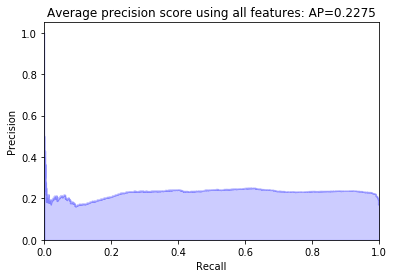

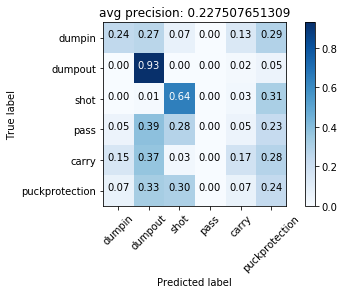

Train: 
Epoch: 2, Loss: 0.194866085491, Accuracy: 0.201409277745
Validation: 
Epoch: 2, Loss: 0.189029124594, Accuracy: 0.186839012926 , Avg Precision: 0.245313897583
Normalized confusion matrix
[[ 0.33333333  0.2         0.02222222  0.          0.26666667  0.17777778]
 [ 0.03571429  0.91071429  0.          0.          0.01785714  0.03571429]
 [ 0.02857143  0.01428571  0.52857143  0.          0.01428571  0.41428571]
 [ 0.05979381  0.39381443  0.22061856  0.          0.07835052  0.24742268]
 [ 0.1409396   0.3557047   0.02013423  0.          0.28187919  0.20134228]
 [ 0.08695652  0.30434783  0.2173913   0.          0.08695652  0.30434783]]


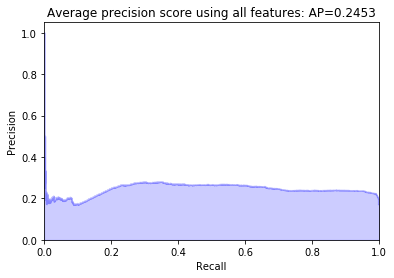

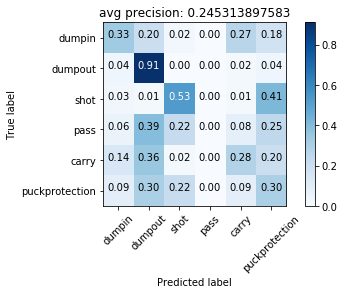

Train: 
Epoch: 3, Loss: 0.182768027499, Accuracy: 0.212566059894
Validation: 
Epoch: 3, Loss: 0.188875631897, Accuracy: 0.202115158637 , Avg Precision: 0.253331129237
Normalized confusion matrix
[[ 0.28888889  0.13333333  0.02222222  0.          0.42222222  0.13333333]
 [ 0.01785714  0.875       0.          0.          0.05357143  0.05357143]
 [ 0.01428571  0.01428571  0.52857143  0.          0.02857143  0.41428571]
 [ 0.05154639  0.36082474  0.21030928  0.          0.10515464  0.27216495]
 [ 0.16778523  0.24161074  0.02013423  0.          0.39597315  0.17449664]
 [ 0.06521739  0.30434783  0.2173913   0.          0.10869565  0.30434783]]


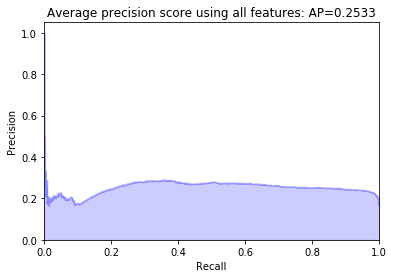

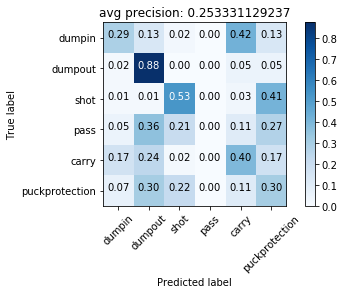

Train: 
Epoch: 4, Loss: 0.171605261651, Accuracy: 0.234879624193
Validation: 
Epoch: 4, Loss: 0.189577252756, Accuracy: 0.213866039953 , Avg Precision: 0.25716864425
Normalized confusion matrix
[[ 0.26666667  0.13333333  0.02222222  0.          0.44444444  0.13333333]
 [ 0.          0.92857143  0.          0.          0.01785714  0.05357143]
 [ 0.01428571  0.01428571  0.55714286  0.          0.02857143  0.38571429]
 [ 0.05360825  0.37113402  0.22061856  0.          0.10515464  0.24948454]
 [ 0.12080537  0.23489933  0.01342282  0.          0.43624161  0.19463087]
 [ 0.06521739  0.2826087   0.23913043  0.          0.10869565  0.30434783]]


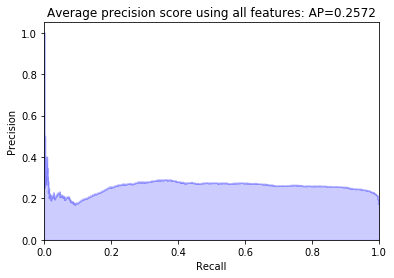

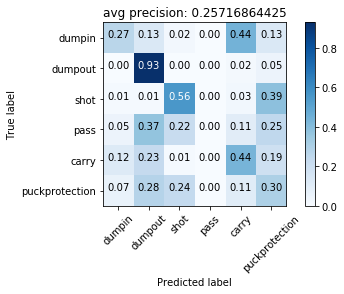

Train: 
Epoch: 5, Loss: 0.157972662943, Accuracy: 0.257486788021
Validation: 
Epoch: 5, Loss: 0.191749208199, Accuracy: 0.216216216216 , Avg Precision: 0.26487139048
Normalized confusion matrix
[[ 0.24444444  0.11111111  0.02222222  0.          0.51111111  0.11111111]
 [ 0.          0.92857143  0.          0.          0.01785714  0.05357143]
 [ 0.01428571  0.01428571  0.52857143  0.          0.04285714  0.4       ]
 [ 0.04536082  0.37113402  0.20618557  0.00412371  0.11340206  0.25979381]
 [ 0.1409396   0.22147651  0.03355705  0.00671141  0.45637584  0.1409396 ]
 [ 0.04347826  0.30434783  0.2173913   0.          0.13043478  0.30434783]]


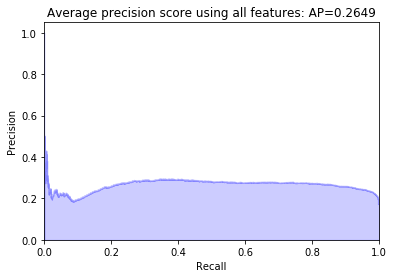

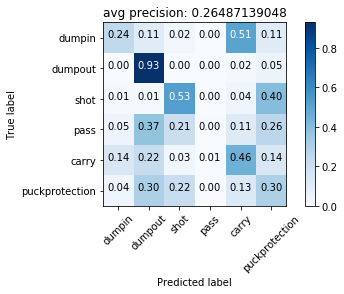

Train: 
Epoch: 6, Loss: 0.141595998742, Accuracy: 0.286846741045
Validation: 
Epoch: 6, Loss: 0.206361233529, Accuracy: 0.216216216216 , Avg Precision: 0.272962373486
Normalized confusion matrix
[[ 0.24444444  0.13333333  0.02222222  0.          0.48888889  0.11111111]
 [ 0.          0.92857143  0.          0.          0.05357143  0.01785714]
 [ 0.01428571  0.01428571  0.48571429  0.02857143  0.05714286  0.4       ]
 [ 0.0371134   0.37319588  0.17113402  0.01649485  0.13402062  0.26804124]
 [ 0.10067114  0.26174497  0.03355705  0.01342282  0.45637584  0.13422819]
 [ 0.02173913  0.30434783  0.19565217  0.02173913  0.2173913   0.23913043]]


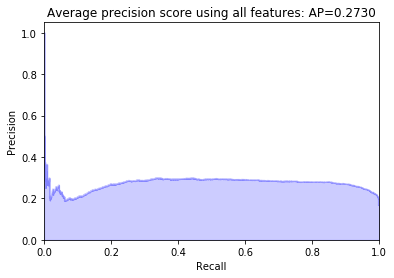

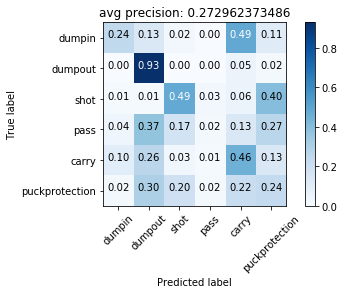

Train: 
Epoch: 7, Loss: 0.124059031415, Accuracy: 0.327363476218
Validation: 
Epoch: 7, Loss: 0.210236672139, Accuracy: 0.244418331375 , Avg Precision: 0.28668808491
Normalized confusion matrix
[[ 0.22222222  0.13333333  0.          0.04444444  0.55555556  0.04444444]
 [ 0.          0.92857143  0.          0.01785714  0.05357143  0.        ]
 [ 0.02857143  0.01428571  0.54285714  0.04285714  0.07142857  0.3       ]
 [ 0.03505155  0.34639175  0.19381443  0.05773196  0.15257732  0.21443299]
 [ 0.10738255  0.23489933  0.03355705  0.04026846  0.46979866  0.11409396]
 [ 0.          0.32608696  0.19565217  0.04347826  0.2173913   0.2173913 ]]


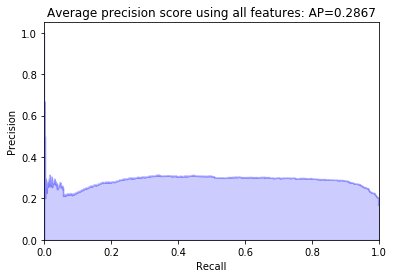

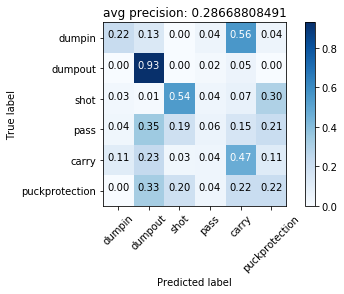

Train: 
Epoch: 8, Loss: 0.10449970902, Accuracy: 0.376394597769
Validation: 
Epoch: 8, Loss: 0.227985684241, Accuracy: 0.243243243243 , Avg Precision: 0.292352144489
Normalized confusion matrix
[[ 0.17777778  0.13333333  0.          0.06666667  0.48888889  0.13333333]
 [ 0.          0.92857143  0.          0.01785714  0.05357143  0.        ]
 [ 0.02857143  0.01428571  0.45714286  0.11428571  0.08571429  0.3       ]
 [ 0.03917526  0.35463918  0.16701031  0.08865979  0.1443299   0.20618557]
 [ 0.12751678  0.24832215  0.02684564  0.06711409  0.41610738  0.11409396]
 [ 0.02173913  0.32608696  0.17391304  0.06521739  0.19565217  0.2173913 ]]


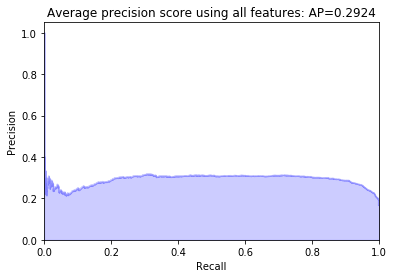

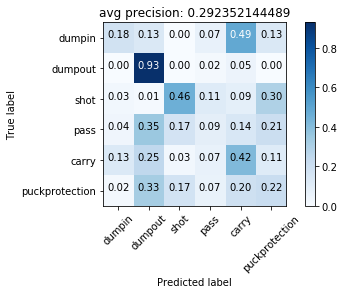

Train: 
Epoch: 9, Loss: 0.0871568325701, Accuracy: 0.432472108045
Validation: 
Epoch: 9, Loss: 0.251211458649, Accuracy: 0.279670975323 , Avg Precision: 0.304264129907
Normalized confusion matrix
[[ 0.17777778  0.15555556  0.          0.04444444  0.51111111  0.11111111]
 [ 0.01785714  0.91071429  0.          0.03571429  0.03571429  0.        ]
 [ 0.02857143  0.01428571  0.41428571  0.21428571  0.1         0.22857143]
 [ 0.04329897  0.34226804  0.13814433  0.15670103  0.14020619  0.17938144]
 [ 0.16778523  0.20134228  0.02013423  0.10738255  0.42281879  0.08053691]
 [ 0.02173913  0.32608696  0.10869565  0.13043478  0.17391304  0.23913043]]


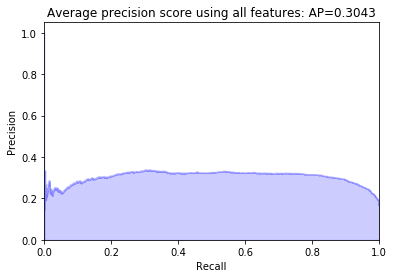

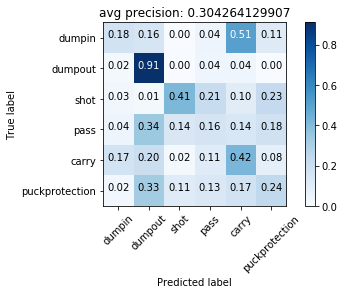

Train: 
Epoch: 10, Loss: 0.0718634156565, Accuracy: 0.479154433353
Validation: 
Epoch: 10, Loss: 0.278496465883, Accuracy: 0.291421856639 , Avg Precision: 0.314892336958
Normalized confusion matrix
[[ 0.11111111  0.2         0.          0.06666667  0.51111111  0.11111111]
 [ 0.          0.92857143  0.          0.01785714  0.05357143  0.        ]
 [ 0.04285714  0.01428571  0.31428571  0.31428571  0.08571429  0.22857143]
 [ 0.04123711  0.35257732  0.11546392  0.21237113  0.12164948  0.15670103]
 [ 0.12751678  0.24832215  0.02013423  0.15436242  0.38255034  0.06711409]
 [ 0.04347826  0.30434783  0.08695652  0.19565217  0.17391304  0.19565217]]


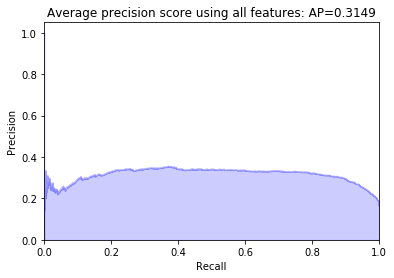

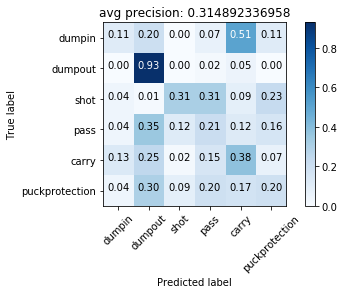

Train: 
Epoch: 11, Loss: 0.0575923464098, Accuracy: 0.54873752202
Validation: 
Epoch: 11, Loss: 0.311189751815, Accuracy: 0.307873090482 , Avg Precision: 0.324113512043
Normalized confusion matrix
[[ 0.04444444  0.22222222  0.          0.13333333  0.51111111  0.08888889]
 [ 0.          0.91071429  0.          0.07142857  0.01785714  0.        ]
 [ 0.01428571  0.01428571  0.3         0.37142857  0.08571429  0.21428571]
 [ 0.02268041  0.35876289  0.08453608  0.26597938  0.11134021  0.15670103]
 [ 0.10738255  0.2885906   0.02013423  0.22147651  0.31543624  0.04697987]
 [ 0.04347826  0.2826087   0.06521739  0.19565217  0.15217391  0.26086957]]


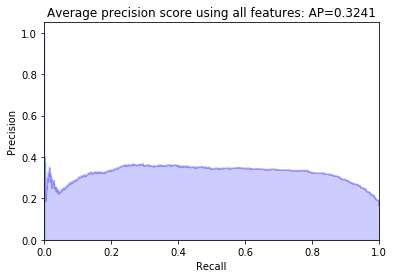

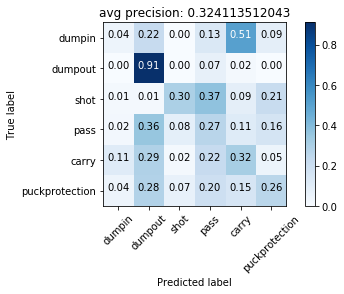

Train: 
Epoch: 12, Loss: 0.0467714309139, Accuracy: 0.591015854375
Validation: 
Epoch: 12, Loss: 0.319657813385, Accuracy: 0.344300822562 , Avg Precision: 0.349693045231
Normalized confusion matrix
[[ 0.02222222  0.15555556  0.          0.13333333  0.62222222  0.06666667]
 [ 0.          0.85714286  0.          0.10714286  0.03571429  0.        ]
 [ 0.02857143  0.          0.27142857  0.42857143  0.1         0.17142857]
 [ 0.0185567   0.29896907  0.09072165  0.31134021  0.14226804  0.13814433]
 [ 0.06040268  0.17449664  0.02013423  0.2885906   0.4295302   0.02684564]
 [ 0.02173913  0.2826087   0.08695652  0.23913043  0.15217391  0.2173913 ]]


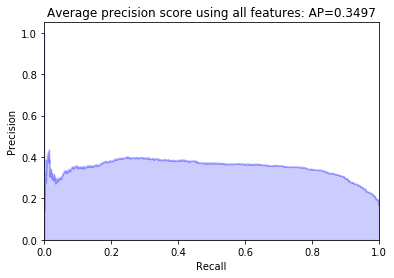

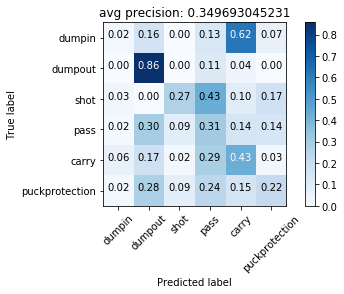

Train: 
Epoch: 13, Loss: 0.0378883502286, Accuracy: 0.649735760423
Validation: 
Epoch: 13, Loss: 0.337750900747, Accuracy: 0.333725029377 , Avg Precision: 0.34223799888
Normalized confusion matrix
[[ 0.08888889  0.17777778  0.02222222  0.15555556  0.51111111  0.04444444]
 [ 0.          0.91071429  0.          0.08928571  0.          0.        ]
 [ 0.02857143  0.          0.32857143  0.37142857  0.1         0.17142857]
 [ 0.02680412  0.33402062  0.12371134  0.29896907  0.11134021  0.10515464]
 [ 0.08724832  0.24161074  0.02684564  0.25503356  0.3557047   0.03355705]
 [ 0.02173913  0.23913043  0.13043478  0.2826087   0.15217391  0.17391304]]


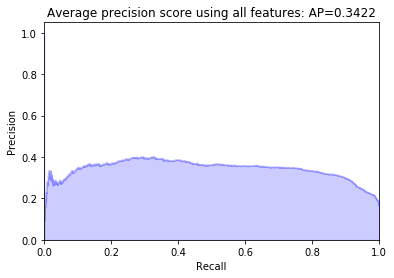

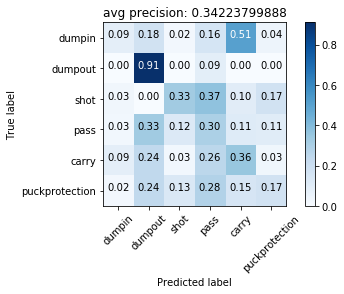

Train: 
Epoch: 14, Loss: 0.0321090092968, Accuracy: 0.695830886671
Validation: 
Epoch: 14, Loss: 0.387300048769, Accuracy: 0.356051703878 , Avg Precision: 0.347968785605
Normalized confusion matrix
[[ 0.02222222  0.24444444  0.          0.26666667  0.4         0.06666667]
 [ 0.          0.875       0.          0.10714286  0.01785714  0.        ]
 [ 0.01428571  0.          0.27142857  0.47142857  0.08571429  0.15714286]
 [ 0.01443299  0.33814433  0.08041237  0.37938144  0.07628866  0.11134021]
 [ 0.04026846  0.31543624  0.02684564  0.26845638  0.28187919  0.06711409]
 [ 0.          0.26086957  0.04347826  0.41304348  0.10869565  0.17391304]]


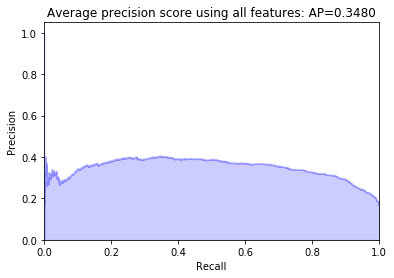

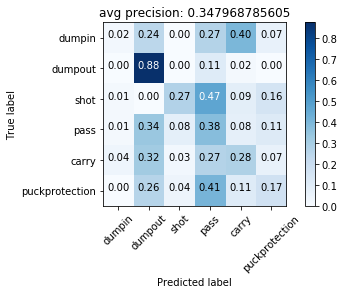

Train: 
Epoch: 15, Loss: 0.0272060080849, Accuracy: 0.733118027011
Validation: 
Epoch: 15, Loss: 0.391967851285, Accuracy: 0.419506462985 , Avg Precision: 0.392746073003
Normalized confusion matrix
[[ 0.04444444  0.08888889  0.          0.33333333  0.46666667  0.06666667]
 [ 0.          0.60714286  0.          0.30357143  0.08928571  0.        ]
 [ 0.02857143  0.          0.15714286  0.6         0.08571429  0.12857143]
 [ 0.01443299  0.20824742  0.05154639  0.49278351  0.14226804  0.09072165]
 [ 0.04697987  0.08053691  0.01342282  0.40268456  0.4295302   0.02684564]
 [ 0.          0.17391304  0.02173913  0.45652174  0.19565217  0.15217391]]


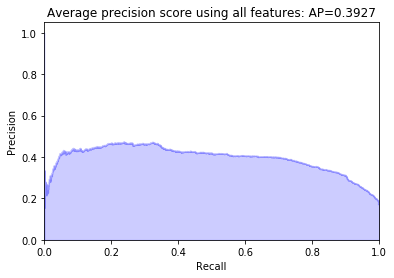

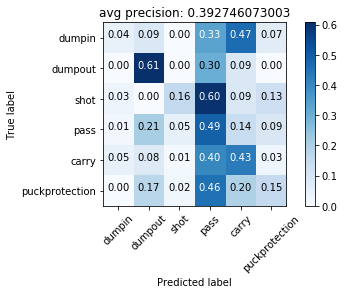

Train: 
Epoch: 16, Loss: 0.0226497771686, Accuracy: 0.764239577217
Validation: 
Epoch: 16, Loss: 0.352341140859, Accuracy: 0.418331374853 , Avg Precision: 0.3896664022
Normalized confusion matrix
[[ 0.08888889  0.06666667  0.          0.31111111  0.42222222  0.11111111]
 [ 0.01785714  0.57142857  0.          0.33928571  0.05357143  0.01785714]
 [ 0.          0.          0.27142857  0.44285714  0.1         0.18571429]
 [ 0.03092784  0.15051546  0.08453608  0.50309278  0.11340206  0.11752577]
 [ 0.08053691  0.06040268  0.00671141  0.44966443  0.32214765  0.08053691]
 [ 0.02173913  0.13043478  0.04347826  0.43478261  0.17391304  0.19565217]]


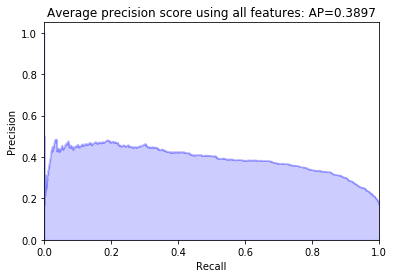

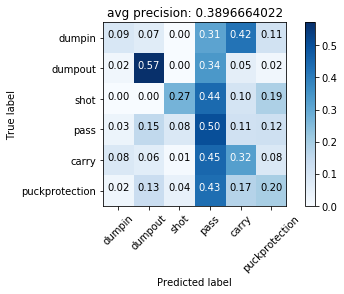

Train: 
Epoch: 17, Loss: 0.0201496671808, Accuracy: 0.793305930711
Validation: 
Epoch: 17, Loss: 0.37386652354, Accuracy: 0.398354876616 , Avg Precision: 0.378602216803
Normalized confusion matrix
[[ 0.02222222  0.11111111  0.02222222  0.28888889  0.46666667  0.08888889]
 [ 0.          0.625       0.          0.32142857  0.05357143  0.        ]
 [ 0.02857143  0.          0.31428571  0.44285714  0.1         0.11428571]
 [ 0.02474227  0.19381443  0.11958763  0.45154639  0.13402062  0.07628866]
 [ 0.06040268  0.12751678  0.04026846  0.34899329  0.36241611  0.06040268]
 [ 0.02173913  0.19565217  0.06521739  0.39130435  0.15217391  0.17391304]]


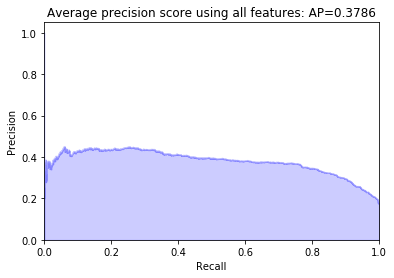

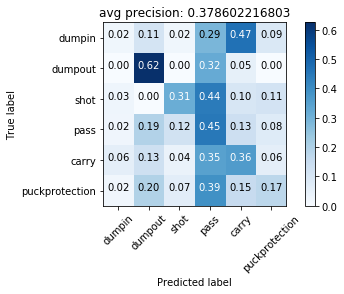

Train: 
Epoch: 18, Loss: 0.0158140545942, Accuracy: 0.825601879037
Validation: 
Epoch: 18, Loss: 0.461025335722, Accuracy: 0.42303172738 , Avg Precision: 0.384697541653
Normalized confusion matrix
[[ 0.          0.24444444  0.          0.31111111  0.4         0.04444444]
 [ 0.          0.83928571  0.          0.16071429  0.          0.        ]
 [ 0.          0.          0.2         0.58571429  0.07142857  0.14285714]
 [ 0.01030928  0.25154639  0.05773196  0.50309278  0.08453608  0.09278351]
 [ 0.05369128  0.20134228  0.02013423  0.36912752  0.31543624  0.04026846]
 [ 0.          0.17391304  0.04347826  0.47826087  0.13043478  0.17391304]]


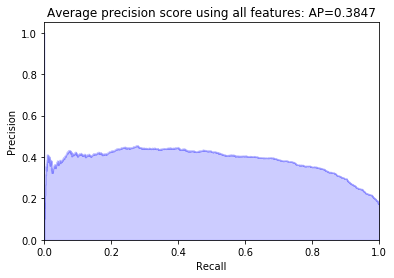

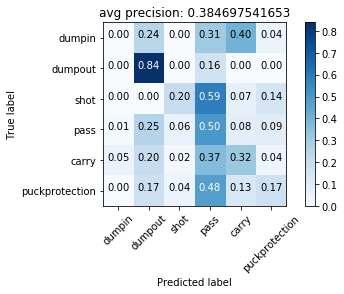

Train: 
Epoch: 19, Loss: 0.0152638210938, Accuracy: 0.845860246624
Validation: 
Epoch: 19, Loss: 0.401903068915, Accuracy: 0.425381903643 , Avg Precision: 0.398154987863
Normalized confusion matrix
[[ 0.          0.08888889  0.06666667  0.37777778  0.4         0.06666667]
 [ 0.          0.46428571  0.01785714  0.42857143  0.08928571  0.        ]
 [ 0.01428571  0.          0.5         0.35714286  0.07142857  0.05714286]
 [ 0.01443299  0.13402062  0.17319588  0.50721649  0.11134021  0.05979381]
 [ 0.02013423  0.04697987  0.08053691  0.48993289  0.32885906  0.03355705]
 [ 0.02173913  0.15217391  0.19565217  0.36956522  0.13043478  0.13043478]]


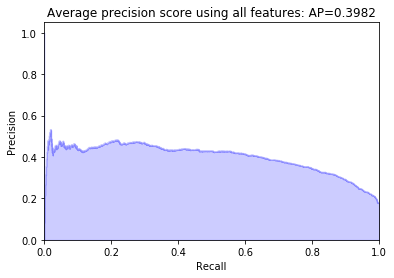

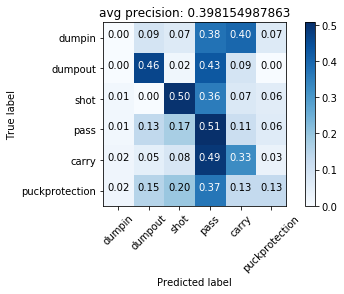

Train: 
Epoch: 20, Loss: 0.0124582529467, Accuracy: 0.873165002936
Validation: 
Epoch: 20, Loss: 0.504860876011, Accuracy: 0.479435957697 , Avg Precision: 0.424513381298
Normalized confusion matrix
[[ 0.04444444  0.15555556  0.          0.42222222  0.35555556  0.02222222]
 [ 0.          0.69642857  0.          0.28571429  0.01785714  0.        ]
 [ 0.          0.01428571  0.12857143  0.77142857  0.07142857  0.01428571]
 [ 0.01237113  0.20824742  0.03917526  0.64742268  0.07835052  0.01443299]
 [ 0.02013423  0.14765101  0.01342282  0.53691275  0.28187919  0.        ]
 [ 0.02173913  0.15217391  0.          0.65217391  0.13043478  0.04347826]]


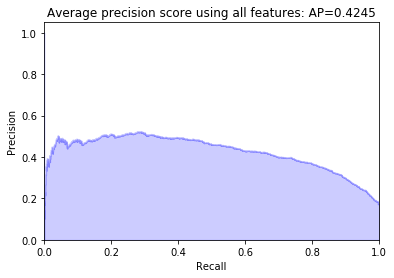

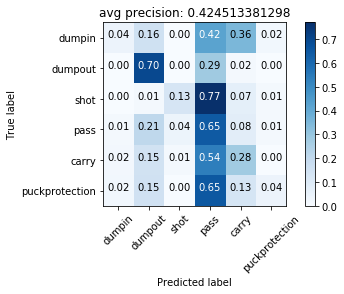

Train: 
Epoch: 21, Loss: 0.0127538788424, Accuracy: 0.879624192601
Validation: 
Epoch: 21, Loss: 0.45160467232, Accuracy: 0.426556991774 , Avg Precision: 0.388171704744
Normalized confusion matrix
[[ 0.02222222  0.08888889  0.          0.31111111  0.44444444  0.13333333]
 [ 0.          0.44642857  0.          0.39285714  0.16071429  0.        ]
 [ 0.02857143  0.          0.08571429  0.57142857  0.11428571  0.2       ]
 [ 0.01237113  0.11134021  0.03298969  0.52371134  0.15257732  0.16701031]
 [ 0.02013423  0.04026846  0.00671141  0.39597315  0.44966443  0.08724832]
 [ 0.04347826  0.10869565  0.02173913  0.36956522  0.23913043  0.2173913 ]]


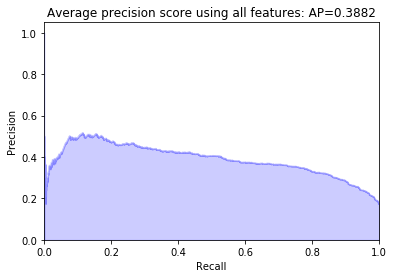

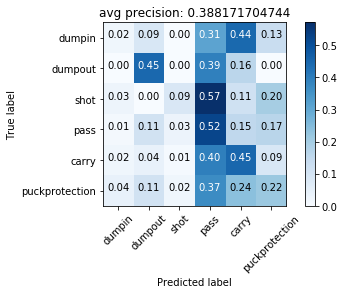

Train: 
Epoch: 22, Loss: 0.0111677745656, Accuracy: 0.892248972402
Validation: 
Epoch: 22, Loss: 0.605497169644, Accuracy: 0.37250293772 , Avg Precision: 0.353580675648
Normalized confusion matrix
[[ 0.          0.35555556  0.          0.26666667  0.33333333  0.04444444]
 [ 0.          0.85714286  0.          0.14285714  0.          0.        ]
 [ 0.          0.02857143  0.11428571  0.64285714  0.1         0.11428571]
 [ 0.00206186  0.36907216  0.02474227  0.44948454  0.08041237  0.0742268 ]
 [ 0.00671141  0.38255034  0.00671141  0.32885906  0.24161074  0.03355705]
 [ 0.          0.34782609  0.04347826  0.34782609  0.10869565  0.15217391]]


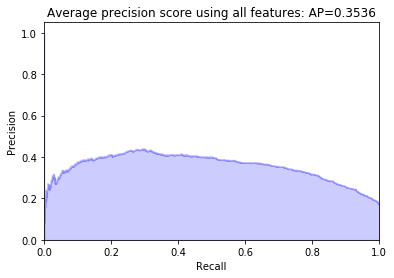

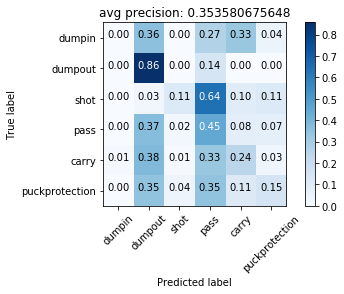

Train: 
Epoch: 23, Loss: 0.0113813024108, Accuracy: 0.900469759248
Validation: 
Epoch: 23, Loss: 0.432826932681, Accuracy: 0.465334900118 , Avg Precision: 0.438458211926
Normalized confusion matrix
[[ 0.          0.08888889  0.02222222  0.37777778  0.44444444  0.06666667]
 [ 0.          0.35714286  0.          0.51785714  0.10714286  0.01785714]
 [ 0.01428571  0.          0.22857143  0.57142857  0.11428571  0.07142857]
 [ 0.0185567   0.09072165  0.0742268   0.58762887  0.15670103  0.07216495]
 [ 0.02013423  0.04697987  0.02013423  0.4295302   0.45637584  0.02684564]
 [ 0.02173913  0.08695652  0.06521739  0.47826087  0.19565217  0.15217391]]


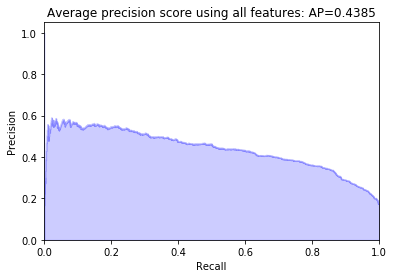

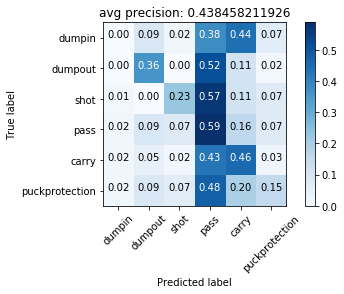

Train: 
Epoch: 24, Loss: 0.00729707704948, Accuracy: 0.933940105696
Validation: 
Epoch: 24, Loss: 0.487069550261, Accuracy: 0.48178613396 , Avg Precision: 0.448024165335
Normalized confusion matrix
[[ 0.          0.08888889  0.02222222  0.53333333  0.31111111  0.04444444]
 [ 0.          0.35714286  0.          0.60714286  0.03571429  0.        ]
 [ 0.01428571  0.          0.21428571  0.62857143  0.05714286  0.08571429]
 [ 0.01030928  0.12164948  0.05360825  0.67010309  0.08247423  0.06185567]
 [ 0.02013423  0.04697987  0.02684564  0.59060403  0.30201342  0.01342282]
 [ 0.02173913  0.10869565  0.06521739  0.52173913  0.17391304  0.10869565]]


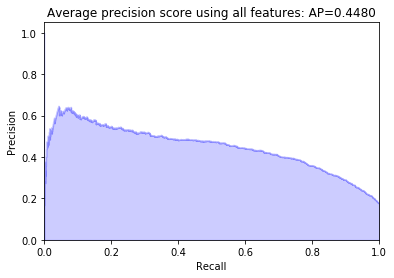

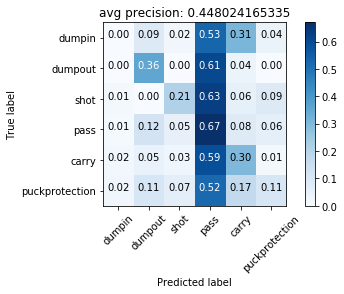

Train: 
Epoch: 25, Loss: 0.00751743968009, Accuracy: 0.936876100998
Validation: 
Epoch: 25, Loss: 0.484239338565, Accuracy: 0.468860164512 , Avg Precision: 0.438357617696
Normalized confusion matrix
[[ 0.          0.08888889  0.          0.53333333  0.28888889  0.08888889]
 [ 0.          0.39285714  0.          0.55357143  0.03571429  0.01785714]
 [ 0.01428571  0.          0.2         0.62857143  0.05714286  0.1       ]
 [ 0.02268041  0.09690722  0.05154639  0.66185567  0.08041237  0.08659794]
 [ 0.05369128  0.03355705  0.02684564  0.60402685  0.23489933  0.04697987]
 [ 0.02173913  0.13043478  0.04347826  0.54347826  0.10869565  0.15217391]]


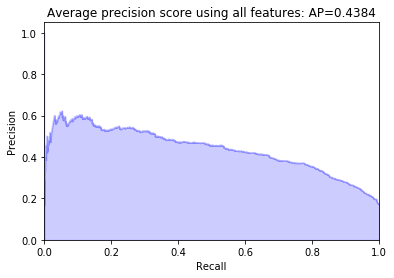

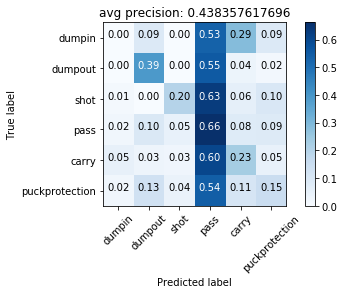

Train: 
Epoch: 26, Loss: 0.00583874415503, Accuracy: 0.948620082208
Validation: 
Epoch: 26, Loss: 0.517566619428, Accuracy: 0.490011750881 , Avg Precision: 0.462809715798
Normalized confusion matrix
[[ 0.02222222  0.06666667  0.          0.62222222  0.17777778  0.11111111]
 [ 0.          0.21428571  0.          0.71428571  0.07142857  0.        ]
 [ 0.01428571  0.          0.1         0.7         0.07142857  0.11428571]
 [ 0.00618557  0.0742268   0.03505155  0.72164948  0.07835052  0.08453608]
 [ 0.02684564  0.02013423  0.02013423  0.59731544  0.26845638  0.06711409]
 [ 0.02173913  0.04347826  0.04347826  0.65217391  0.08695652  0.15217391]]


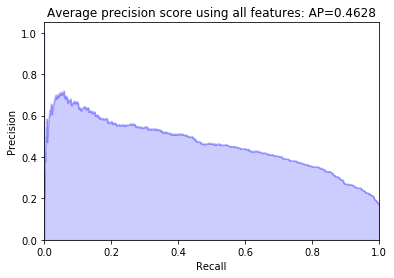

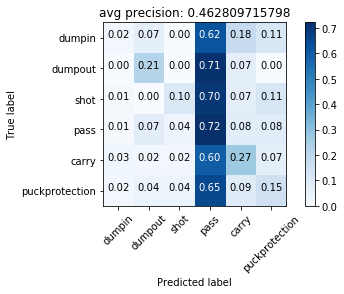

Train: 
Epoch: 27, Loss: 0.00596838665347, Accuracy: 0.949794480329
Validation: 
Epoch: 27, Loss: 0.524733634087, Accuracy: 0.432432432432 , Avg Precision: 0.409307499358
Normalized confusion matrix
[[ 0.          0.06666667  0.          0.48888889  0.31111111  0.13333333]
 [ 0.          0.14285714  0.          0.73214286  0.08928571  0.03571429]
 [ 0.01428571  0.          0.12857143  0.52857143  0.05714286  0.27142857]
 [ 0.00824742  0.05154639  0.04123711  0.60412371  0.09484536  0.2       ]
 [ 0.02013423  0.02013423  0.01342282  0.5033557   0.30872483  0.13422819]
 [ 0.04347826  0.06521739  0.02173913  0.47826087  0.13043478  0.26086957]]


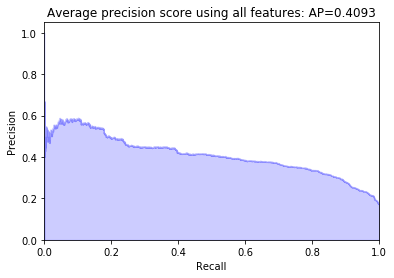

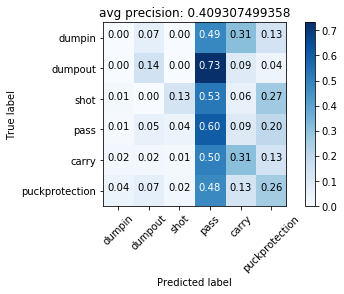

Train: 
Epoch: 28, Loss: 0.0049146344239, Accuracy: 0.958896065766
Validation: 
Epoch: 28, Loss: 0.565564178199, Accuracy: 0.417156286722 , Avg Precision: 0.392701574319
Normalized confusion matrix
[[ 0.02222222  0.17777778  0.          0.55555556  0.11111111  0.13333333]
 [ 0.          0.5         0.          0.5         0.          0.        ]
 [ 0.04285714  0.01428571  0.08571429  0.65714286  0.02857143  0.17142857]
 [ 0.02886598  0.21443299  0.02268041  0.59587629  0.02886598  0.10927835]
 [ 0.08724832  0.16107383  0.01342282  0.52348993  0.1409396   0.0738255 ]
 [ 0.06521739  0.17391304  0.          0.5         0.04347826  0.2173913 ]]


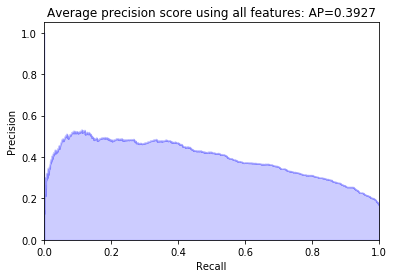

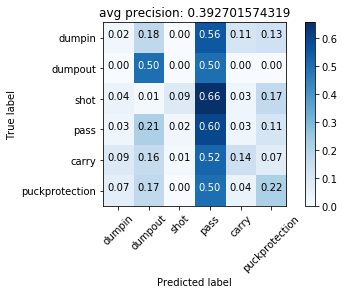

Train: 
Epoch: 29, Loss: 0.00591955324861, Accuracy: 0.958602466236
Validation: 
Epoch: 29, Loss: 0.532023244617, Accuracy: 0.507638072855 , Avg Precision: 0.471531571704
Normalized confusion matrix
[[ 0.          0.06666667  0.          0.57777778  0.24444444  0.11111111]
 [ 0.          0.26785714  0.          0.66071429  0.05357143  0.01785714]
 [ 0.01428571  0.          0.14285714  0.67142857  0.04285714  0.12857143]
 [ 0.00824742  0.07010309  0.03505155  0.74020619  0.0556701   0.09072165]
 [ 0.03355705  0.01342282  0.01342282  0.59060403  0.27516779  0.0738255 ]
 [ 0.02173913  0.06521739  0.04347826  0.56521739  0.15217391  0.15217391]]


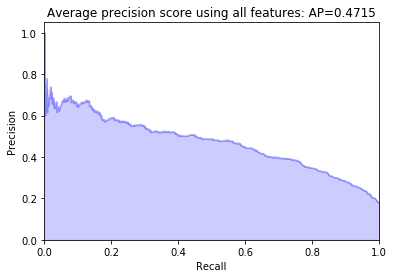

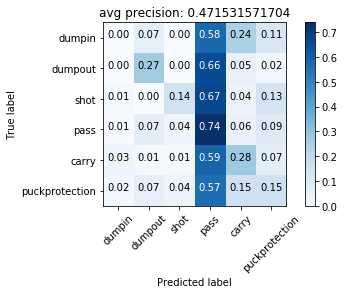

Train: 
Epoch: 30, Loss: 0.00402763601505, Accuracy: 0.968291250734
Validation: 
Epoch: 30, Loss: 0.529810810816, Accuracy: 0.502937720329 , Avg Precision: 0.455585944093
Normalized confusion matrix
[[ 0.          0.08888889  0.          0.48888889  0.33333333  0.08888889]
 [ 0.          0.30357143  0.          0.625       0.07142857  0.        ]
 [ 0.          0.          0.21428571  0.64285714  0.02857143  0.11428571]
 [ 0.01030928  0.08247423  0.05154639  0.68453608  0.10515464  0.06597938]
 [ 0.02684564  0.04697987  0.02013423  0.48993289  0.39597315  0.02013423]
 [ 0.          0.04347826  0.04347826  0.56521739  0.23913043  0.10869565]]


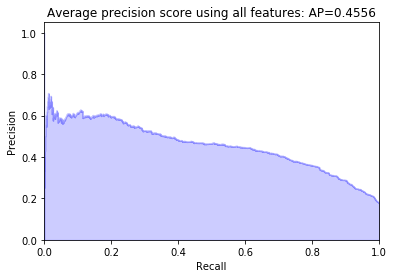

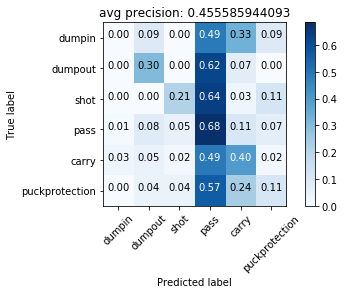

Train: 
Epoch: 31, Loss: 0.00467941546489, Accuracy: 0.961538461538
Validation: 
Epoch: 31, Loss: 0.506426688717, Accuracy: 0.455934195065 , Avg Precision: 0.438947764939
Normalized confusion matrix
[[ 0.          0.02222222  0.02222222  0.46666667  0.26666667  0.22222222]
 [ 0.01785714  0.16071429  0.01785714  0.71428571  0.          0.08928571]
 [ 0.01428571  0.          0.32857143  0.47142857  0.02857143  0.15714286]
 [ 0.01237113  0.05979381  0.10309278  0.6556701   0.05979381  0.10927835]
 [ 0.03355705  0.00671141  0.06711409  0.59060403  0.18791946  0.11409396]
 [ 0.02173913  0.06521739  0.13043478  0.43478261  0.13043478  0.2173913 ]]


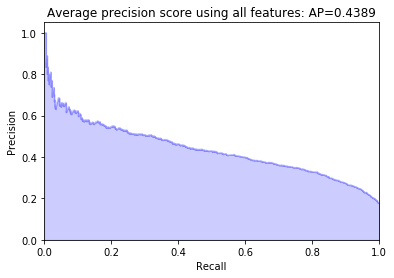

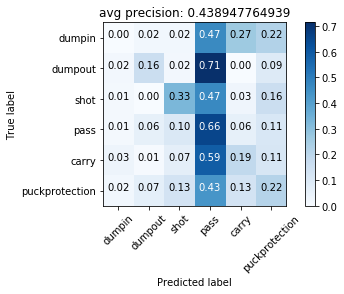

Train: 
Epoch: 32, Loss: 0.00395861146053, Accuracy: 0.970933646506
Validation: 
Epoch: 32, Loss: 0.522067192081, Accuracy: 0.487661574618 , Avg Precision: 0.477786489194
Normalized confusion matrix
[[ 0.02222222  0.06666667  0.          0.6         0.2         0.11111111]
 [ 0.          0.16071429  0.01785714  0.80357143  0.01785714  0.        ]
 [ 0.01428571  0.          0.18571429  0.67142857  0.01428571  0.11428571]
 [ 0.01649485  0.05773196  0.04948454  0.74020619  0.04123711  0.09484536]
 [ 0.01342282  0.02013423  0.03355705  0.7114094   0.18791946  0.03355705]
 [ 0.          0.04347826  0.08695652  0.67391304  0.08695652  0.10869565]]


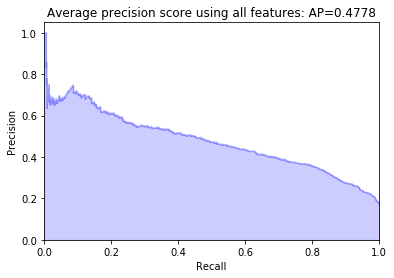

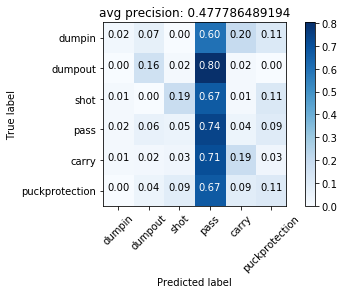

Train: 
Epoch: 33, Loss: 0.00319812404188, Accuracy: 0.978273634762
Validation: 
Epoch: 33, Loss: 0.523256483117, Accuracy: 0.384253819036 , Avg Precision: 0.3709780042
Normalized confusion matrix
[[ 0.06666667  0.02222222  0.02222222  0.4         0.15555556  0.33333333]
 [ 0.03571429  0.26785714  0.01785714  0.53571429  0.01785714  0.125     ]
 [ 0.          0.          0.25714286  0.41428571  0.01428571  0.31428571]
 [ 0.02268041  0.06804124  0.05979381  0.50721649  0.05773196  0.28453608]
 [ 0.03355705  0.02684564  0.02684564  0.48993289  0.15436242  0.26845638]
 [ 0.02173913  0.04347826  0.04347826  0.39130435  0.02173913  0.47826087]]


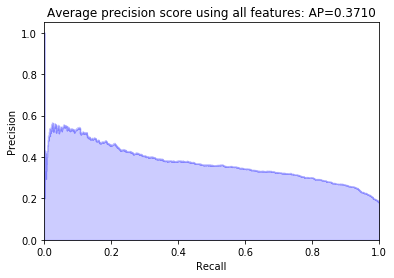

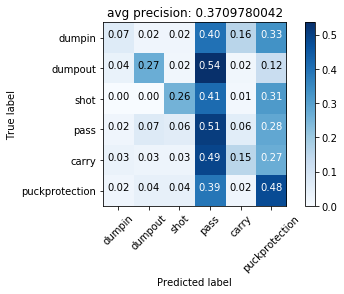

Train: 
Epoch: 34, Loss: 0.00368793464865, Accuracy: 0.974163241339
Validation: 
Epoch: 34, Loss: 0.61471066945, Accuracy: 0.535840188014 , Avg Precision: 0.502694807058
Normalized confusion matrix
[[ 0.          0.06666667  0.          0.64444444  0.28888889  0.        ]
 [ 0.          0.16071429  0.          0.78571429  0.05357143  0.        ]
 [ 0.01428571  0.          0.22857143  0.67142857  0.07142857  0.01428571]
 [ 0.00206186  0.05773196  0.05979381  0.78762887  0.07835052  0.01443299]
 [ 0.00671141  0.01342282  0.06040268  0.60402685  0.30872483  0.00671141]
 [ 0.          0.02173913  0.06521739  0.63043478  0.2173913   0.06521739]]


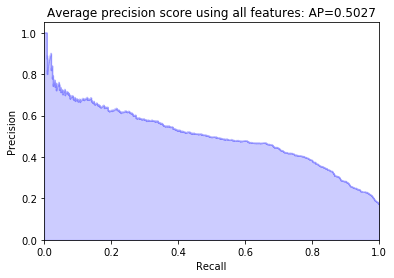

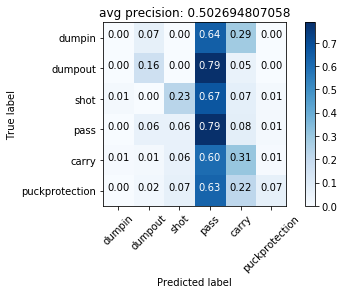

Train: 
Epoch: 35, Loss: 0.00356833380087, Accuracy: 0.977686435702
Validation: 
Epoch: 35, Loss: 0.521731752927, Accuracy: 0.465334900118 , Avg Precision: 0.438467371575
Normalized confusion matrix
[[ 0.          0.04444444  0.06666667  0.57777778  0.17777778  0.13333333]
 [ 0.          0.25        0.          0.71428571  0.03571429  0.        ]
 [ 0.01428571  0.          0.27142857  0.55714286  0.01428571  0.14285714]
 [ 0.01443299  0.08041237  0.06804124  0.6742268   0.0556701   0.10721649]
 [ 0.02684564  0.04697987  0.04697987  0.59060403  0.20134228  0.08724832]
 [ 0.04347826  0.08695652  0.06521739  0.58695652  0.08695652  0.13043478]]


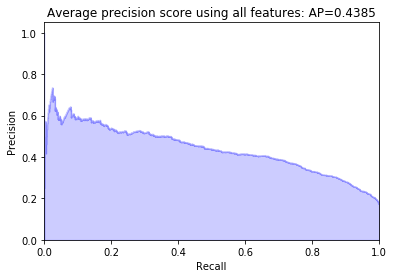

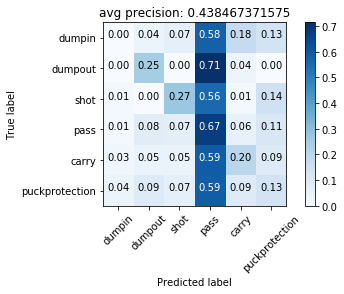

Train: 
Epoch: 36, Loss: 0.00246075210831, Accuracy: 0.983558426307
Validation: 
Epoch: 36, Loss: 0.462733599074, Accuracy: 0.426556991774 , Avg Precision: 0.394662030574
Normalized confusion matrix
[[ 0.28888889  0.04444444  0.04444444  0.28888889  0.2         0.13333333]
 [ 0.08928571  0.35714286  0.01785714  0.44642857  0.05357143  0.03571429]
 [ 0.08571429  0.          0.32857143  0.44285714  0.05714286  0.08571429]
 [ 0.10927835  0.09690722  0.10103093  0.55051546  0.07628866  0.06597938]
 [ 0.30201342  0.03355705  0.03355705  0.38926174  0.22818792  0.01342282]
 [ 0.15217391  0.10869565  0.13043478  0.41304348  0.06521739  0.13043478]]


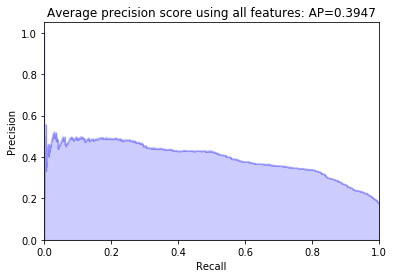

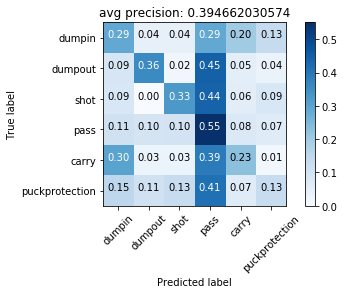

Train: 
Epoch: 37, Loss: 0.00328971159858, Accuracy: 0.977099236641
Validation: 
Epoch: 37, Loss: 0.535302074731, Accuracy: 0.482961222092 , Avg Precision: 0.448247434586
Normalized confusion matrix
[[ 0.04444444  0.06666667  0.11111111  0.37777778  0.35555556  0.04444444]
 [ 0.01785714  0.21428571  0.01785714  0.69642857  0.05357143  0.        ]
 [ 0.02857143  0.          0.25714286  0.51428571  0.1         0.1       ]
 [ 0.02680412  0.06804124  0.08453608  0.65773196  0.10515464  0.05773196]
 [ 0.0738255   0.01342282  0.04026846  0.4966443   0.36241611  0.01342282]
 [ 0.04347826  0.08695652  0.06521739  0.5         0.17391304  0.13043478]]


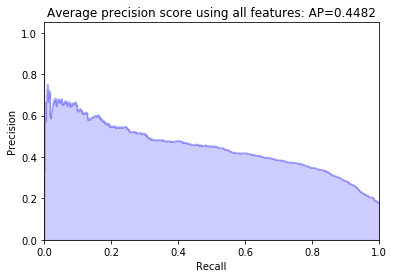

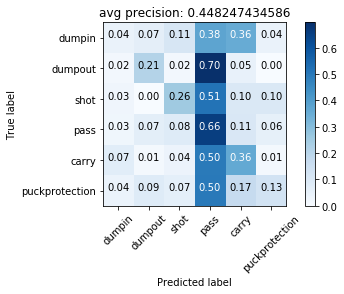

Train: 
Epoch: 38, Loss: 0.00339532114505, Accuracy: 0.982384028186
Validation: 
Epoch: 38, Loss: 0.541489665486, Accuracy: 0.472385428907 , Avg Precision: 0.447063020116
Normalized confusion matrix
[[ 0.04444444  0.06666667  0.          0.48888889  0.28888889  0.11111111]
 [ 0.          0.21428571  0.01785714  0.73214286  0.03571429  0.        ]
 [ 0.02857143  0.          0.28571429  0.54285714  0.05714286  0.08571429]
 [ 0.01030928  0.07835052  0.08247423  0.64329897  0.10515464  0.08041237]
 [ 0.04026846  0.02684564  0.06711409  0.4966443   0.33557047  0.03355705]
 [ 0.02173913  0.06521739  0.08695652  0.54347826  0.15217391  0.13043478]]


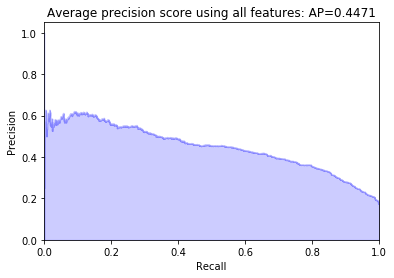

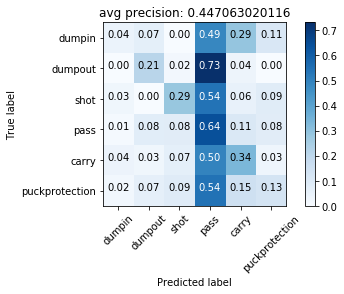

Train: 
Epoch: 39, Loss: 0.00346443234395, Accuracy: 0.979154433353
Validation: 
Epoch: 39, Loss: 0.716577792628, Accuracy: 0.366627497062 , Avg Precision: 0.357217757962
Normalized confusion matrix
[[ 0.04444444  0.4         0.          0.35555556  0.17777778  0.02222222]
 [ 0.          0.66071429  0.          0.33928571  0.          0.        ]
 [ 0.          0.14285714  0.15714286  0.55714286  0.05714286  0.08571429]
 [ 0.01030928  0.37525773  0.03505155  0.48865979  0.04948454  0.04123711]
 [ 0.03355705  0.40268456  0.00671141  0.39597315  0.14765101  0.01342282]
 [ 0.          0.43478261  0.02173913  0.36956522  0.10869565  0.06521739]]


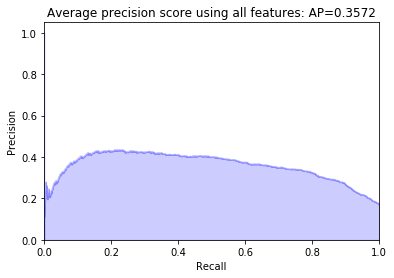

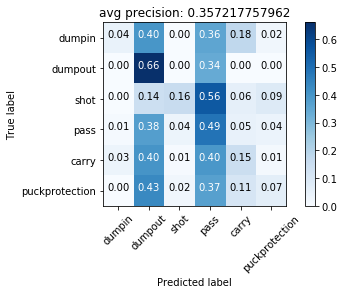

Train: 
Epoch: 40, Loss: 0.00460562491251, Accuracy: 0.976805637111
Validation: 
Epoch: 40, Loss: 0.59923898743, Accuracy: 0.426556991774 , Avg Precision: 0.394406635821
Normalized confusion matrix
[[ 0.          0.06666667  0.          0.42222222  0.33333333  0.17777778]
 [ 0.          0.30357143  0.01785714  0.55357143  0.07142857  0.05357143]
 [ 0.          0.          0.1         0.5         0.08571429  0.31428571]
 [ 0.00206186  0.08247423  0.0185567   0.5443299   0.11340206  0.23917526]
 [ 0.02013423  0.01342282  0.00671141  0.41610738  0.4295302   0.11409396]
 [ 0.          0.08695652  0.02173913  0.39130435  0.26086957  0.23913043]]


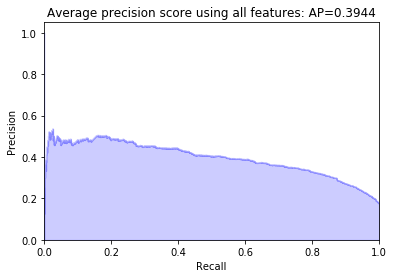

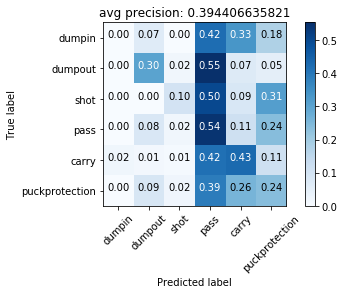

Train: 
Epoch: 41, Loss: 0.00269657798112, Accuracy: 0.984732824427
Validation: 
Epoch: 41, Loss: 0.589775109063, Accuracy: 0.51821386604 , Avg Precision: 0.485736601424
Normalized confusion matrix
[[ 0.02222222  0.08888889  0.          0.57777778  0.26666667  0.04444444]
 [ 0.          0.25        0.01785714  0.67857143  0.05357143  0.        ]
 [ 0.01428571  0.          0.25714286  0.67142857  0.04285714  0.01428571]
 [ 0.01030928  0.08247423  0.08041237  0.73608247  0.08659794  0.00412371]
 [ 0.04026846  0.03355705  0.03355705  0.56375839  0.32214765  0.00671141]
 [ 0.          0.02173913  0.06521739  0.67391304  0.17391304  0.06521739]]


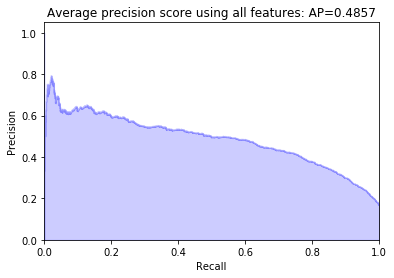

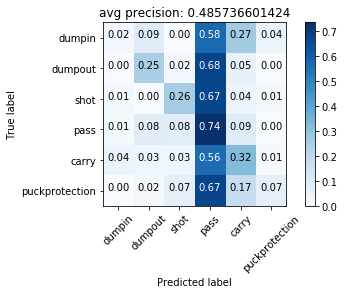

Train: 
Epoch: 42, Loss: 0.00190195915527, Accuracy: 0.990017615972
Validation: 
Epoch: 42, Loss: 0.536039032486, Accuracy: 0.414806110458 , Avg Precision: 0.39556538243
Normalized confusion matrix
[[ 0.          0.2         0.          0.26666667  0.42222222  0.11111111]
 [ 0.          0.48214286  0.          0.41071429  0.07142857  0.03571429]
 [ 0.01428571  0.          0.31428571  0.5         0.1         0.07142857]
 [ 0.0371134   0.17319588  0.09690722  0.48659794  0.14845361  0.05773196]
 [ 0.06711409  0.10067114  0.04026846  0.36241611  0.41610738  0.01342282]
 [ 0.04347826  0.15217391  0.06521739  0.32608696  0.2826087   0.13043478]]


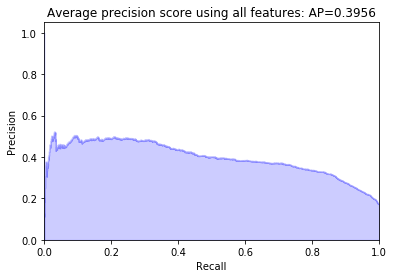

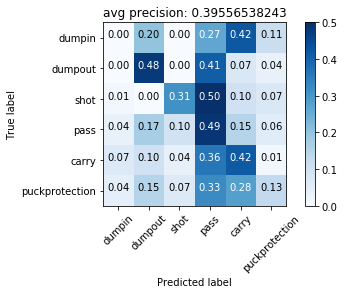

Train: 
Epoch: 43, Loss: 0.00232062812464, Accuracy: 0.985320023488
Validation: 
Epoch: 43, Loss: 0.594293970192, Accuracy: 0.497062279671 , Avg Precision: 0.465083024847
Normalized confusion matrix
[[ 0.02222222  0.08888889  0.          0.46666667  0.37777778  0.04444444]
 [ 0.          0.30357143  0.          0.60714286  0.08928571  0.        ]
 [ 0.01428571  0.          0.18571429  0.65714286  0.1         0.04285714]
 [ 0.0185567   0.10515464  0.05154639  0.68247423  0.1257732   0.01649485]
 [ 0.04026846  0.02684564  0.02684564  0.51006711  0.38926174  0.00671141]
 [ 0.02173913  0.06521739  0.06521739  0.54347826  0.23913043  0.06521739]]


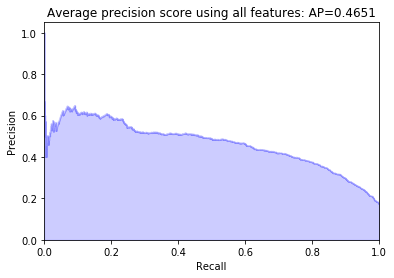

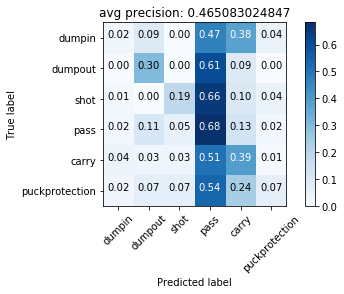

Train: 
Epoch: 44, Loss: 0.00228757309027, Accuracy: 0.985907222548
Validation: 
Epoch: 44, Loss: 0.551772992522, Accuracy: 0.475910693302 , Avg Precision: 0.46385256253
Normalized confusion matrix
[[ 0.04444444  0.04444444  0.          0.46666667  0.33333333  0.11111111]
 [ 0.          0.17857143  0.          0.67857143  0.08928571  0.05357143]
 [ 0.01428571  0.          0.21428571  0.58571429  0.05714286  0.12857143]
 [ 0.0185567   0.04948454  0.06391753  0.68659794  0.07010309  0.11134021]
 [ 0.08724832  0.          0.02684564  0.55704698  0.24832215  0.08053691]
 [ 0.02173913  0.04347826  0.04347826  0.56521739  0.15217391  0.17391304]]


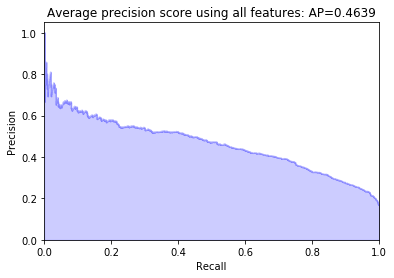

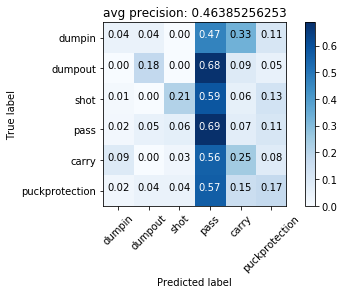

Train: 
Epoch: 45, Loss: 0.00322831462296, Accuracy: 0.980916030534
Validation: 
Epoch: 45, Loss: 0.607869805458, Accuracy: 0.514688601645 , Avg Precision: 0.489515425257
Normalized confusion matrix
[[ 0.          0.11111111  0.06666667  0.46666667  0.28888889  0.06666667]
 [ 0.01785714  0.25        0.01785714  0.625       0.08928571  0.        ]
 [ 0.01428571  0.          0.18571429  0.67142857  0.1         0.02857143]
 [ 0.0185567   0.07010309  0.05979381  0.73402062  0.09690722  0.02061856]
 [ 0.04026846  0.02013423  0.02013423  0.57718121  0.33557047  0.00671141]
 [ 0.          0.04347826  0.02173913  0.60869565  0.2173913   0.10869565]]


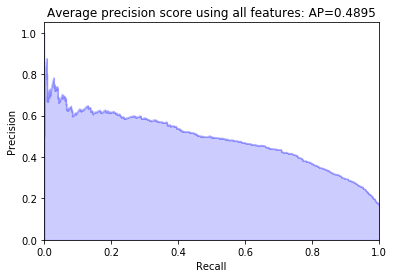

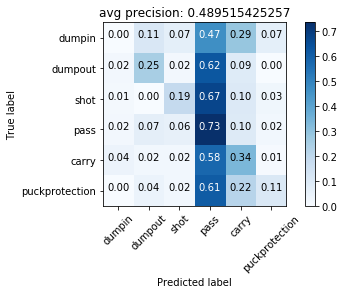

Train: 
Epoch: 46, Loss: 0.0025929870372, Accuracy: 0.985320023488
Validation: 
Epoch: 46, Loss: 0.534947204017, Accuracy: 0.482961222092 , Avg Precision: 0.466811432994
Normalized confusion matrix
[[ 0.02222222  0.08888889  0.          0.57777778  0.22222222  0.08888889]
 [ 0.03571429  0.17857143  0.          0.71428571  0.03571429  0.03571429]
 [ 0.02857143  0.          0.18571429  0.65714286  0.02857143  0.1       ]
 [ 0.03092784  0.05979381  0.05773196  0.70515464  0.07216495  0.0742268 ]
 [ 0.0738255   0.03355705  0.03355705  0.53020134  0.24161074  0.08724832]
 [ 0.08695652  0.02173913  0.04347826  0.52173913  0.13043478  0.19565217]]


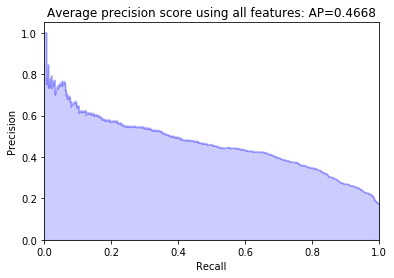

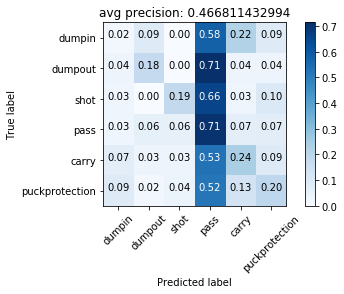

Train: 
Epoch: 47, Loss: 0.00190454463592, Accuracy: 0.989724016442
Validation: 
Epoch: 47, Loss: 0.614236077554, Accuracy: 0.521739130435 , Avg Precision: 0.486684042957
Normalized confusion matrix
[[ 0.06666667  0.13333333  0.          0.57777778  0.2         0.02222222]
 [ 0.          0.32142857  0.01785714  0.58928571  0.05357143  0.01785714]
 [ 0.01428571  0.          0.15714286  0.77142857  0.04285714  0.01428571]
 [ 0.03092784  0.08659794  0.03092784  0.76907216  0.07010309  0.01237113]
 [ 0.06711409  0.04026846  0.02013423  0.62416107  0.24161074  0.00671141]
 [ 0.08695652  0.02173913  0.04347826  0.7173913   0.06521739  0.06521739]]


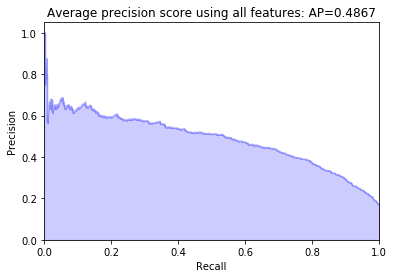

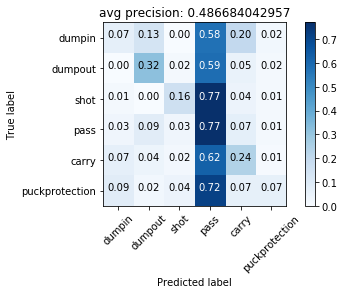

Train: 
Epoch: 48, Loss: 0.00151033371859, Accuracy: 0.989430416911
Validation: 
Epoch: 48, Loss: 0.578560277309, Accuracy: 0.494712103408 , Avg Precision: 0.456111273246
Normalized confusion matrix
[[ 0.02222222  0.06666667  0.          0.51111111  0.33333333  0.06666667]
 [ 0.01785714  0.21428571  0.          0.67857143  0.08928571  0.        ]
 [ 0.01428571  0.          0.25714286  0.62857143  0.07142857  0.02857143]
 [ 0.03092784  0.07628866  0.06804124  0.68865979  0.10721649  0.02886598]
 [ 0.06711409  0.04026846  0.04697987  0.4966443   0.34228188  0.00671141]
 [ 0.02173913  0.06521739  0.10869565  0.5         0.19565217  0.10869565]]


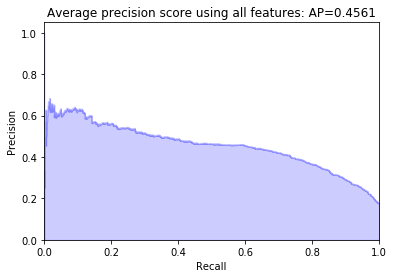

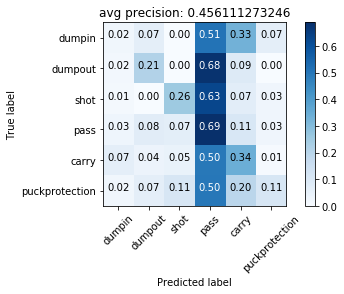

Train: 
Epoch: 49, Loss: 0.00202397215269, Accuracy: 0.984439224897
Validation: 
Epoch: 49, Loss: 0.548685111507, Accuracy: 0.457109283196 , Avg Precision: 0.431393142319
Normalized confusion matrix
[[ 0.          0.13333333  0.02222222  0.28888889  0.37777778  0.17777778]
 [ 0.          0.35714286  0.          0.53571429  0.08928571  0.01785714]
 [ 0.01428571  0.          0.28571429  0.51428571  0.07142857  0.11428571]
 [ 0.01443299  0.09278351  0.08041237  0.59793814  0.10515464  0.10927835]
 [ 0.02684564  0.06711409  0.04026846  0.44295302  0.34899329  0.0738255 ]
 [ 0.02173913  0.08695652  0.04347826  0.45652174  0.23913043  0.15217391]]


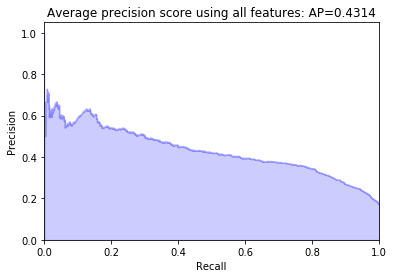

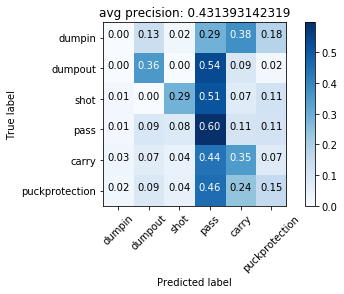

Train: 
Epoch: 50, Loss: 0.00218245955308, Accuracy: 0.98796241926
Validation: 
Epoch: 50, Loss: 0.584812610304, Accuracy: 0.484136310223 , Avg Precision: 0.458136662109
Normalized confusion matrix
[[ 0.04444444  0.11111111  0.06666667  0.42222222  0.31111111  0.04444444]
 [ 0.01785714  0.30357143  0.01785714  0.58928571  0.05357143  0.01785714]
 [ 0.01428571  0.          0.21428571  0.64285714  0.08571429  0.04285714]
 [ 0.03092784  0.08041237  0.06391753  0.68453608  0.09484536  0.04536082]
 [ 0.0738255   0.02684564  0.04026846  0.57718121  0.26845638  0.01342282]
 [ 0.04347826  0.06521739  0.04347826  0.54347826  0.17391304  0.13043478]]


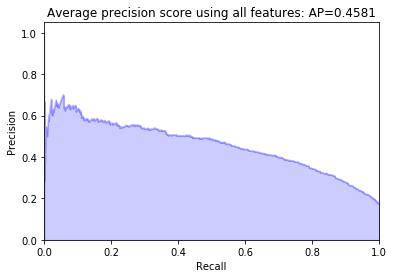

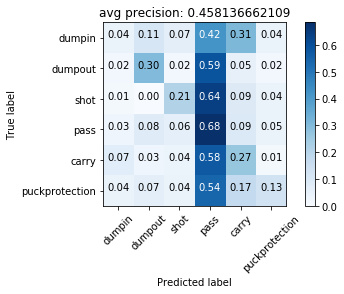

Train: 
Epoch: 51, Loss: 0.00254298760869, Accuracy: 0.985320023488
Validation: 
Epoch: 51, Loss: 0.647369870605, Accuracy: 0.534665099882 , Avg Precision: 0.500498395144
Normalized confusion matrix
[[ 0.02222222  0.04444444  0.          0.62222222  0.26666667  0.04444444]
 [ 0.01785714  0.07142857  0.          0.83928571  0.05357143  0.01785714]
 [ 0.01428571  0.          0.15714286  0.75714286  0.02857143  0.04285714]
 [ 0.01237113  0.04948454  0.02886598  0.78556701  0.09072165  0.03298969]
 [ 0.02013423  0.          0.02684564  0.58389262  0.36241611  0.00671141]
 [ 0.02173913  0.04347826  0.04347826  0.54347826  0.26086957  0.08695652]]


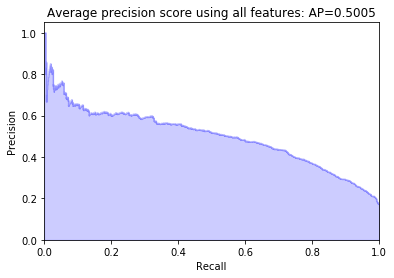

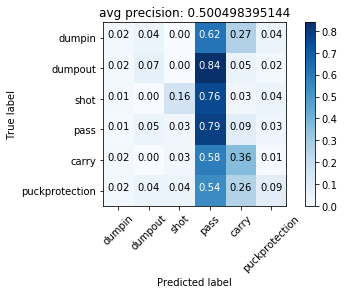

Train: 
Epoch: 52, Loss: 0.00237379567099, Accuracy: 0.988549618321
Validation: 
Epoch: 52, Loss: 0.60309370337, Accuracy: 0.486486486486 , Avg Precision: 0.462241275578
Normalized confusion matrix
[[ 0.02222222  0.08888889  0.02222222  0.35555556  0.44444444  0.06666667]
 [ 0.01785714  0.26785714  0.          0.55357143  0.14285714  0.01785714]
 [ 0.01428571  0.          0.27142857  0.52857143  0.12857143  0.05714286]
 [ 0.03505155  0.06391753  0.08453608  0.64329897  0.14226804  0.03092784]
 [ 0.10067114  0.01342282  0.03355705  0.41610738  0.4295302   0.00671141]
 [ 0.06521739  0.02173913  0.08695652  0.47826087  0.2826087   0.06521739]]


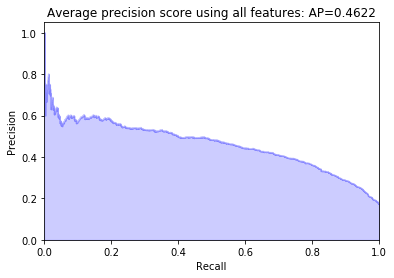

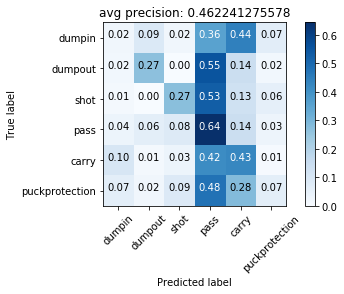

Train: 
Epoch: 53, Loss: 0.001311882592, Accuracy: 0.988843217851
Validation: 
Epoch: 53, Loss: 0.610087022205, Accuracy: 0.502937720329 , Avg Precision: 0.477665843485
Normalized confusion matrix
[[ 0.04444444  0.08888889  0.          0.51111111  0.33333333  0.02222222]
 [ 0.01785714  0.21428571  0.          0.67857143  0.08928571  0.        ]
 [ 0.01428571  0.          0.12857143  0.71428571  0.08571429  0.05714286]
 [ 0.01649485  0.07628866  0.02680412  0.71134021  0.12164948  0.04742268]
 [ 0.05369128  0.02013423  0.02013423  0.5033557   0.36912752  0.03355705]
 [ 0.02173913  0.02173913  0.04347826  0.58695652  0.2173913   0.10869565]]


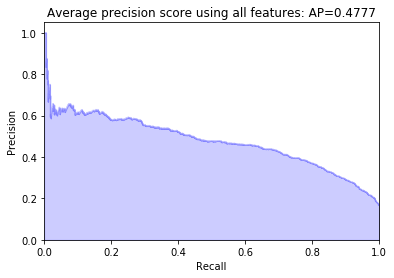

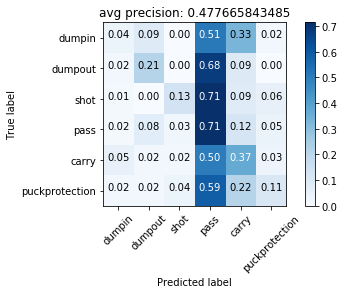

Train: 
Epoch: 54, Loss: 0.00226364624167, Accuracy: 0.989430416911
Validation: 
Epoch: 54, Loss: 0.589163618975, Accuracy: 0.494712103408 , Avg Precision: 0.46240556775
Normalized confusion matrix
[[ 0.06666667  0.08888889  0.02222222  0.4         0.31111111  0.11111111]
 [ 0.          0.375       0.          0.55357143  0.05357143  0.01785714]
 [ 0.02857143  0.          0.21428571  0.61428571  0.07142857  0.07142857]
 [ 0.03092784  0.08659794  0.05154639  0.66185567  0.08247423  0.08659794]
 [ 0.06040268  0.06711409  0.02684564  0.45637584  0.3557047   0.03355705]
 [ 0.04347826  0.04347826  0.06521739  0.5         0.17391304  0.17391304]]


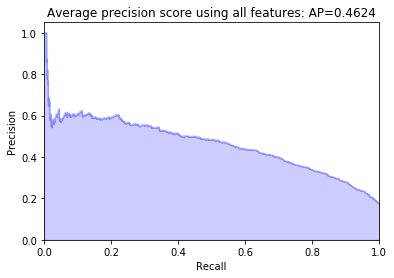

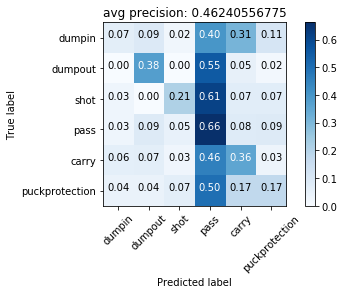

Train: 
Epoch: 55, Loss: 0.00170400699699, Accuracy: 0.98766881973
Validation: 
Epoch: 55, Loss: 0.580108412272, Accuracy: 0.466509988249 , Avg Precision: 0.43212067322
Normalized confusion matrix
[[ 0.02222222  0.13333333  0.          0.4         0.33333333  0.11111111]
 [ 0.01785714  0.41071429  0.01785714  0.48214286  0.01785714  0.05357143]
 [ 0.02857143  0.          0.22857143  0.62857143  0.05714286  0.05714286]
 [ 0.02680412  0.1257732   0.0742268   0.6185567   0.07010309  0.08453608]
 [ 0.06040268  0.10067114  0.02684564  0.42281879  0.34899329  0.04026846]
 [ 0.04347826  0.10869565  0.06521739  0.45652174  0.2173913   0.10869565]]


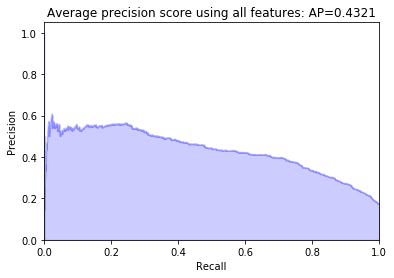

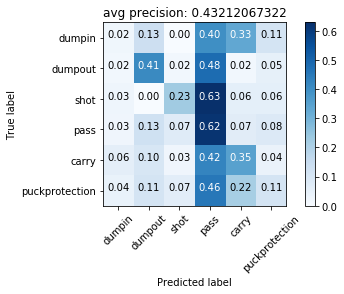

Train: 
Epoch: 56, Loss: 0.00203591128228, Accuracy: 0.990604815032
Validation: 
Epoch: 56, Loss: 0.627065527969, Accuracy: 0.507638072855 , Avg Precision: 0.474778374197
Normalized confusion matrix
[[ 0.06666667  0.11111111  0.          0.51111111  0.24444444  0.06666667]
 [ 0.          0.19642857  0.          0.73214286  0.05357143  0.01785714]
 [ 0.04285714  0.          0.14285714  0.68571429  0.07142857  0.05714286]
 [ 0.03505155  0.08453608  0.04123711  0.72989691  0.06391753  0.04536082]
 [ 0.0738255   0.03355705  0.01342282  0.53020134  0.32885906  0.02013423]
 [ 0.06521739  0.02173913  0.04347826  0.58695652  0.17391304  0.10869565]]


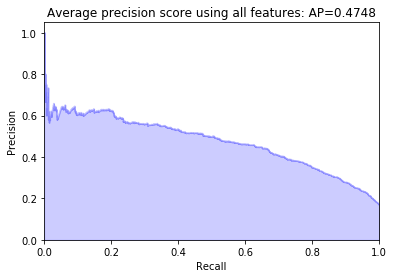

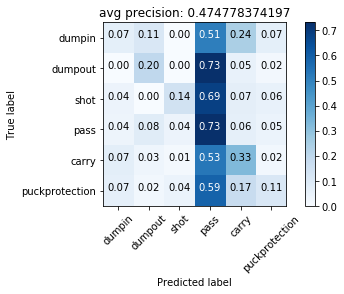

Train: 
Epoch: 57, Loss: 0.00130165109377, Accuracy: 0.992072812683
Validation: 
Epoch: 57, Loss: 0.611448419694, Accuracy: 0.468860164512 , Avg Precision: 0.445900571489
Normalized confusion matrix
[[ 0.06666667  0.08888889  0.02222222  0.42222222  0.33333333  0.06666667]
 [ 0.          0.19642857  0.01785714  0.71428571  0.07142857  0.        ]
 [ 0.02857143  0.          0.31428571  0.48571429  0.11428571  0.05714286]
 [ 0.02474227  0.08659794  0.09278351  0.61443299  0.12989691  0.05154639]
 [ 0.06711409  0.04026846  0.03355705  0.42281879  0.41610738  0.02013423]
 [ 0.06521739  0.02173913  0.06521739  0.54347826  0.23913043  0.06521739]]


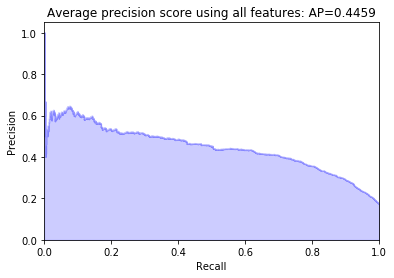

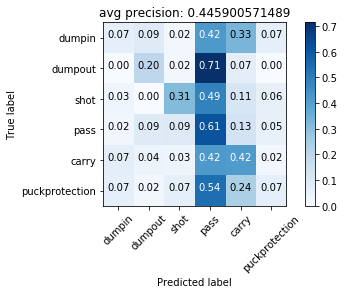

Train: 
Epoch: 58, Loss: 0.00231726663394, Accuracy: 0.989724016442
Validation: 
Epoch: 58, Loss: 0.578082705111, Accuracy: 0.471210340776 , Avg Precision: 0.443150707855
Normalized confusion matrix
[[ 0.04444444  0.08888889  0.02222222  0.37777778  0.37777778  0.08888889]
 [ 0.01785714  0.21428571  0.01785714  0.67857143  0.05357143  0.01785714]
 [ 0.01428571  0.          0.27142857  0.52857143  0.11428571  0.07142857]
 [ 0.03298969  0.0742268   0.07216495  0.63092784  0.13402062  0.0556701 ]
 [ 0.08724832  0.02013423  0.02684564  0.44295302  0.38255034  0.04026846]
 [ 0.08695652  0.04347826  0.04347826  0.47826087  0.23913043  0.10869565]]


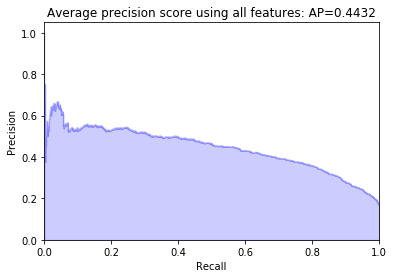

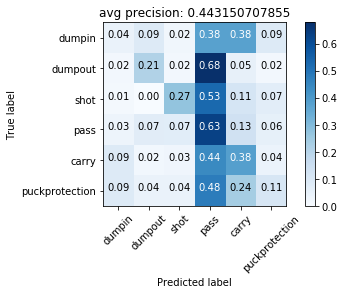

Train: 
Epoch: 59, Loss: 0.00130261958212, Accuracy: 0.991192014093
Validation: 
Epoch: 59, Loss: 0.606578188989, Accuracy: 0.479435957697 , Avg Precision: 0.452697478648
Normalized confusion matrix
[[ 0.06666667  0.08888889  0.04444444  0.35555556  0.37777778  0.06666667]
 [ 0.          0.28571429  0.01785714  0.58928571  0.08928571  0.01785714]
 [ 0.02857143  0.          0.25714286  0.54285714  0.11428571  0.05714286]
 [ 0.03092784  0.08453608  0.0742268   0.62474227  0.13402062  0.05154639]
 [ 0.0738255   0.01342282  0.02684564  0.44966443  0.40939597  0.02684564]
 [ 0.06521739  0.02173913  0.06521739  0.45652174  0.23913043  0.15217391]]


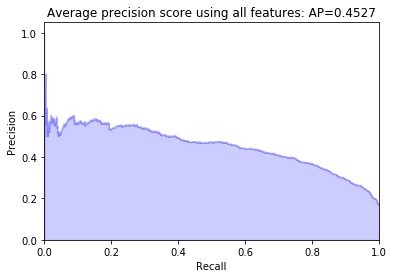

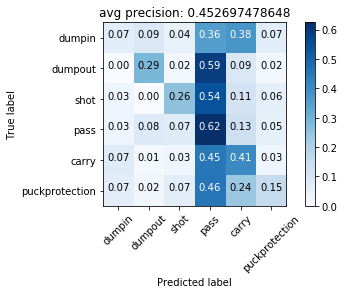

Train: 
Epoch: 60, Loss: 0.00136814806171, Accuracy: 0.990311215502
Validation: 
Epoch: 60, Loss: 0.718661225631, Accuracy: 0.520564042303 , Avg Precision: 0.479794849332
Normalized confusion matrix
[[ 0.          0.08888889  0.          0.44444444  0.42222222  0.04444444]
 [ 0.          0.17857143  0.          0.69642857  0.125       0.        ]
 [ 0.01428571  0.          0.15714286  0.67142857  0.11428571  0.04285714]
 [ 0.01443299  0.06597938  0.01443299  0.7257732   0.15257732  0.02680412]
 [ 0.04026846  0.00671141  0.00671141  0.51677852  0.4295302   0.        ]
 [ 0.02173913  0.02173913  0.04347826  0.52173913  0.26086957  0.13043478]]


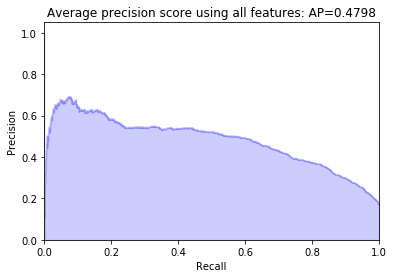

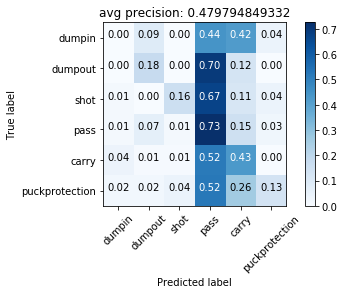

Train: 
Epoch: 61, Loss: 0.00146341378738, Accuracy: 0.989136817381
Validation: 
Epoch: 61, Loss: 0.593252382539, Accuracy: 0.45240893067 , Avg Precision: 0.42783320203
Normalized confusion matrix
[[ 0.06666667  0.06666667  0.04444444  0.35555556  0.4         0.06666667]
 [ 0.05357143  0.32142857  0.          0.5         0.10714286  0.01785714]
 [ 0.02857143  0.          0.22857143  0.57142857  0.08571429  0.08571429]
 [ 0.0371134   0.10515464  0.07835052  0.57113402  0.1443299   0.06391753]
 [ 0.06711409  0.04697987  0.02684564  0.41610738  0.4295302   0.01342282]
 [ 0.04347826  0.10869565  0.02173913  0.41304348  0.26086957  0.15217391]]


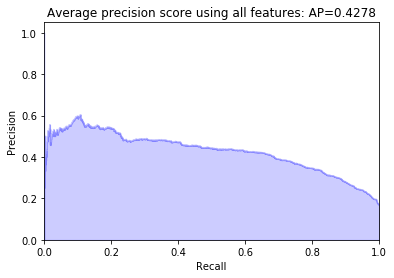

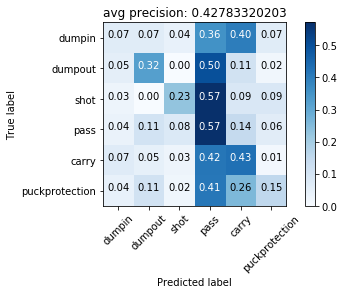

Train: 
Epoch: 62, Loss: 0.00145623383858, Accuracy: 0.992072812683
Validation: 
Epoch: 62, Loss: 0.525808929957, Accuracy: 0.424206815511 , Avg Precision: 0.421177007217
Normalized confusion matrix
[[ 0.08888889  0.04444444  0.          0.33333333  0.37777778  0.15555556]
 [ 0.01785714  0.16071429  0.03571429  0.60714286  0.16071429  0.01785714]
 [ 0.02857143  0.          0.28571429  0.48571429  0.08571429  0.11428571]
 [ 0.0556701   0.0742268   0.06391753  0.53402062  0.17731959  0.09484536]
 [ 0.11409396  0.01342282  0.04026846  0.36241611  0.40939597  0.06040268]
 [ 0.10869565  0.04347826  0.08695652  0.36956522  0.2173913   0.17391304]]


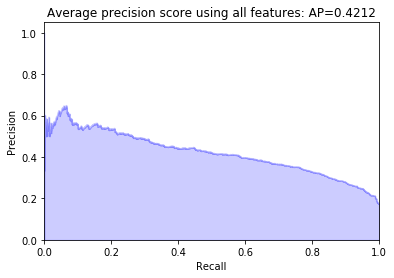

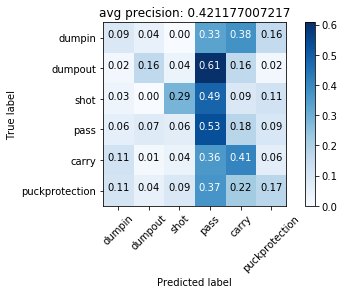

Train: 
Epoch: 63, Loss: 0.0017198505391, Accuracy: 0.989136817381
Validation: 
Epoch: 63, Loss: 0.562696149594, Accuracy: 0.433607520564 , Avg Precision: 0.423101908181
Normalized confusion matrix
[[ 0.02222222  0.04444444  0.02222222  0.44444444  0.28888889  0.17777778]
 [ 0.01785714  0.07142857  0.01785714  0.76785714  0.08928571  0.03571429]
 [ 0.          0.          0.31428571  0.5         0.05714286  0.12857143]
 [ 0.02268041  0.04948454  0.10927835  0.58969072  0.10927835  0.11958763]
 [ 0.0738255   0.00671141  0.05369128  0.46979866  0.31543624  0.08053691]
 [ 0.02173913  0.04347826  0.10869565  0.36956522  0.26086957  0.19565217]]


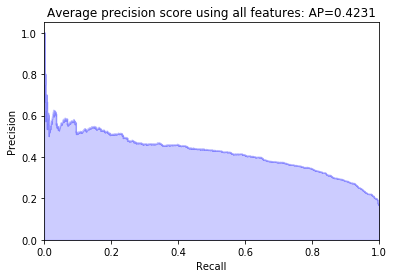

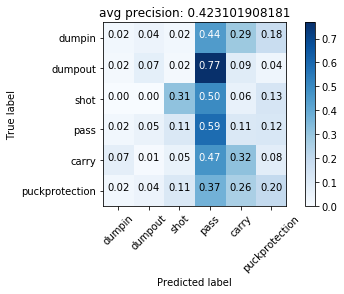

Train: 
Epoch: 64, Loss: 0.000915515037136, Accuracy: 0.995302407516
Validation: 
Epoch: 64, Loss: 0.617390199224, Accuracy: 0.491186839013 , Avg Precision: 0.465719589498
Normalized confusion matrix
[[ 0.04444444  0.15555556  0.          0.4         0.31111111  0.08888889]
 [ 0.01785714  0.26785714  0.01785714  0.57142857  0.08928571  0.03571429]
 [ 0.04285714  0.          0.21428571  0.57142857  0.08571429  0.08571429]
 [ 0.02061856  0.0742268   0.04536082  0.66185567  0.13402062  0.06391753]
 [ 0.08053691  0.02684564  0.02684564  0.44966443  0.39597315  0.02013423]
 [ 0.02173913  0.04347826  0.04347826  0.5         0.26086957  0.13043478]]


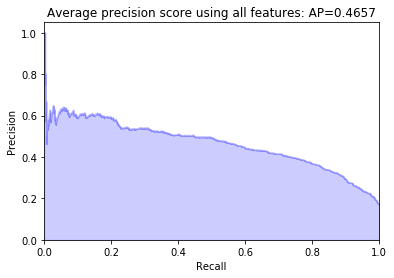

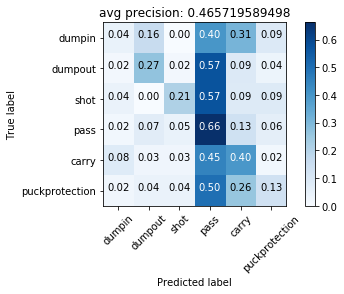

Train: 
Epoch: 65, Loss: 0.0013231707268, Accuracy: 0.989430416911
Validation: 
Epoch: 65, Loss: 0.5800689216, Accuracy: 0.405405405405 , Avg Precision: 0.37028211037
Normalized confusion matrix
[[ 0.04444444  0.04444444  0.2         0.24444444  0.4         0.06666667]
 [ 0.01785714  0.25        0.03571429  0.55357143  0.125       0.01785714]
 [ 0.01428571  0.          0.58571429  0.27142857  0.1         0.02857143]
 [ 0.03917526  0.07010309  0.23092784  0.45773196  0.15051546  0.05154639]
 [ 0.10067114  0.02684564  0.16107383  0.30872483  0.39597315  0.00671141]
 [ 0.04347826  0.08695652  0.26086957  0.19565217  0.26086957  0.15217391]]


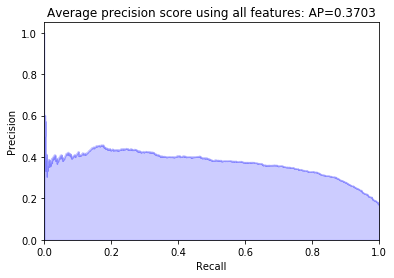

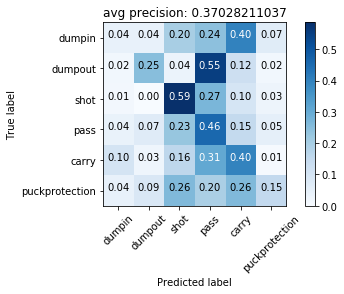

Train: 
Epoch: 66, Loss: 0.00217524233184, Accuracy: 0.988843217851
Validation: 
Epoch: 66, Loss: 0.641627184507, Accuracy: 0.467685076381 , Avg Precision: 0.43706003357
Normalized confusion matrix
[[ 0.02222222  0.2         0.02222222  0.44444444  0.22222222  0.08888889]
 [ 0.01785714  0.26785714  0.01785714  0.64285714  0.03571429  0.01785714]
 [ 0.01428571  0.          0.15714286  0.64285714  0.11428571  0.07142857]
 [ 0.02061856  0.10721649  0.04329897  0.65360825  0.09896907  0.07628866]
 [ 0.04697987  0.08053691  0.02013423  0.4966443   0.32214765  0.03355705]
 [ 0.04347826  0.08695652  0.08695652  0.39130435  0.26086957  0.13043478]]


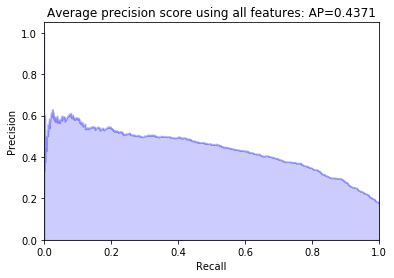

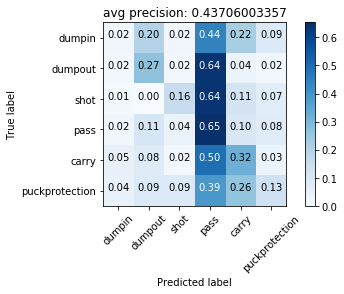

Train: 
Epoch: 67, Loss: 0.00153420805236, Accuracy: 0.988549618321
Validation: 
Epoch: 67, Loss: 0.768127162271, Accuracy: 0.453584018801 , Avg Precision: 0.396666424104
Normalized confusion matrix
[[ 0.04444444  0.33333333  0.02222222  0.35555556  0.2         0.04444444]
 [ 0.          0.71428571  0.          0.25        0.03571429  0.        ]
 [ 0.01428571  0.          0.14285714  0.78571429  0.04285714  0.01428571]
 [ 0.01443299  0.27010309  0.03505155  0.61443299  0.05360825  0.01237113]
 [ 0.04026846  0.32214765  0.02013423  0.38926174  0.22818792  0.        ]
 [ 0.04347826  0.23913043  0.04347826  0.47826087  0.15217391  0.04347826]]


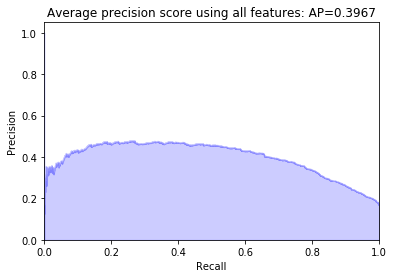

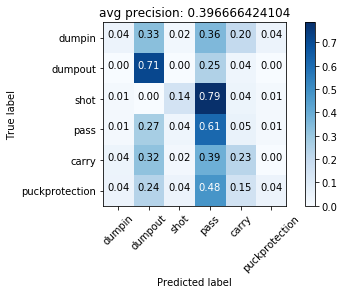

Train: 
Epoch: 68, Loss: 0.00130197802244, Accuracy: 0.990311215502
Validation: 
Epoch: 68, Loss: 0.54343915923, Accuracy: 0.451233842538 , Avg Precision: 0.43488115462
Normalized confusion matrix
[[ 0.06666667  0.04444444  0.04444444  0.33333333  0.31111111  0.2       ]
 [ 0.01785714  0.26785714  0.03571429  0.60714286  0.05357143  0.01785714]
 [ 0.01428571  0.          0.34285714  0.45714286  0.08571429  0.1       ]
 [ 0.03092784  0.08247423  0.10927835  0.56494845  0.11546392  0.09690722]
 [ 0.0738255   0.02684564  0.04697987  0.40939597  0.38255034  0.06040268]
 [ 0.02173913  0.02173913  0.08695652  0.41304348  0.2173913   0.23913043]]


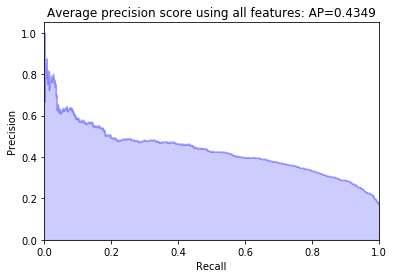

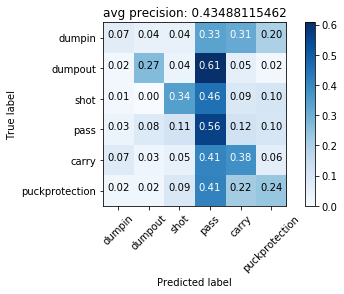

Train: 
Epoch: 69, Loss: 0.00249185244656, Accuracy: 0.985613623018
Validation: 
Epoch: 69, Loss: 0.55130066908, Accuracy: 0.443008225617 , Avg Precision: 0.430143755445
Normalized confusion matrix
[[ 0.2         0.06666667  0.06666667  0.42222222  0.13333333  0.11111111]
 [ 0.05357143  0.32142857  0.01785714  0.55357143  0.05357143  0.        ]
 [ 0.05714286  0.          0.32857143  0.48571429  0.07142857  0.05714286]
 [ 0.08453608  0.08453608  0.11958763  0.58762887  0.07010309  0.05360825]
 [ 0.20134228  0.01342282  0.03355705  0.48993289  0.24161074  0.02013423]
 [ 0.10869565  0.04347826  0.15217391  0.34782609  0.2173913   0.13043478]]


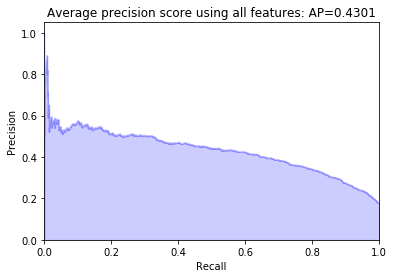

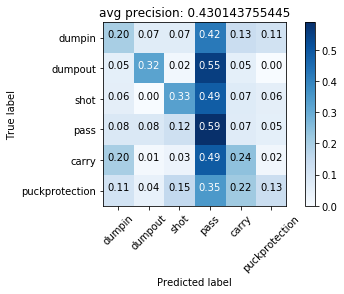

Train: 
Epoch: 70, Loss: 0.00173879739538, Accuracy: 0.986788021139
Validation: 
Epoch: 70, Loss: 0.618802823096, Accuracy: 0.495887191539 , Avg Precision: 0.454097692811
Normalized confusion matrix
[[ 0.          0.04444444  0.02222222  0.46666667  0.31111111  0.15555556]
 [ 0.          0.28571429  0.03571429  0.55357143  0.10714286  0.01785714]
 [ 0.01428571  0.          0.27142857  0.55714286  0.04285714  0.11428571]
 [ 0.00824742  0.07010309  0.07835052  0.66804124  0.07628866  0.09896907]
 [ 0.02684564  0.04026846  0.05369128  0.44966443  0.3557047   0.0738255 ]
 [ 0.          0.04347826  0.06521739  0.43478261  0.23913043  0.2173913 ]]


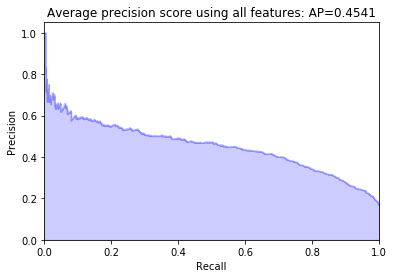

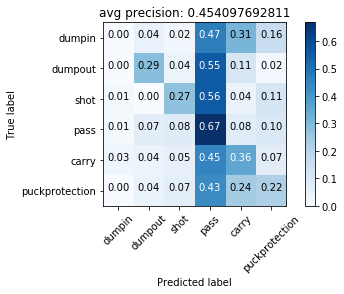

Train: 
Epoch: 71, Loss: 0.000697437037472, Accuracy: 0.995008807986
Validation: 
Epoch: 71, Loss: 0.595509276339, Accuracy: 0.508813160987 , Avg Precision: 0.496268627447
Normalized confusion matrix
[[ 0.          0.11111111  0.02222222  0.55555556  0.22222222  0.08888889]
 [ 0.01785714  0.17857143  0.05357143  0.66071429  0.08928571  0.        ]
 [ 0.01428571  0.          0.27142857  0.61428571  0.05714286  0.04285714]
 [ 0.0185567   0.06804124  0.05360825  0.74226804  0.08865979  0.02886598]
 [ 0.0738255   0.01342282  0.04026846  0.61073826  0.25503356  0.00671141]
 [ 0.04347826  0.02173913  0.06521739  0.63043478  0.10869565  0.13043478]]


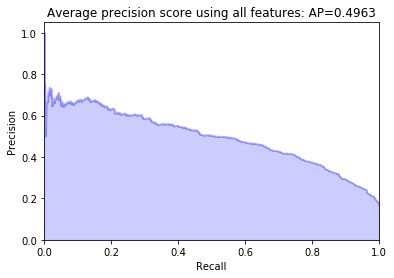

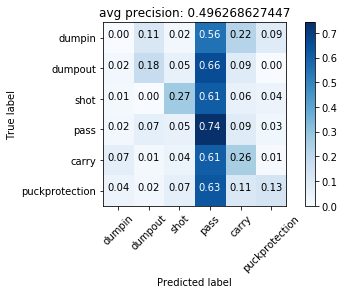

Train: 
Epoch: 72, Loss: 0.000678068218193, Accuracy: 0.995302407516
Validation: 
Epoch: 72, Loss: 0.645871042961, Accuracy: 0.504112808461 , Avg Precision: 0.46883669598
Normalized confusion matrix
[[ 0.04444444  0.06666667  0.04444444  0.31111111  0.44444444  0.08888889]
 [ 0.          0.19642857  0.01785714  0.55357143  0.23214286  0.        ]
 [ 0.01428571  0.          0.2         0.61428571  0.12857143  0.04285714]
 [ 0.02268041  0.05773196  0.03917526  0.65773196  0.1814433   0.04123711]
 [ 0.06040268  0.00671141  0.02013423  0.40268456  0.51006711  0.        ]
 [ 0.06521739  0.04347826  0.06521739  0.34782609  0.32608696  0.15217391]]


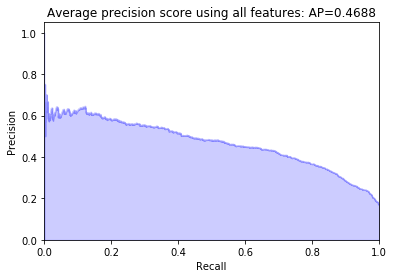

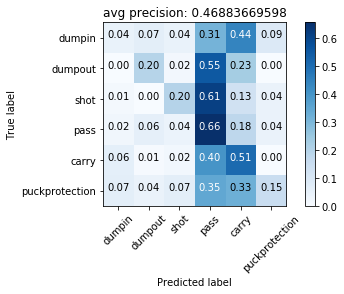

Train: 
Epoch: 73, Loss: 0.000984397858789, Accuracy: 0.990898414563
Validation: 
Epoch: 73, Loss: 0.637875166279, Accuracy: 0.479435957697 , Avg Precision: 0.490105417189
Normalized confusion matrix
[[ 0.02222222  0.06666667  0.02222222  0.6         0.22222222  0.06666667]
 [ 0.01785714  0.23214286  0.          0.64285714  0.08928571  0.01785714]
 [ 0.01428571  0.          0.17142857  0.68571429  0.05714286  0.07142857]
 [ 0.03505155  0.07835052  0.05360825  0.71546392  0.08659794  0.03092784]
 [ 0.08053691  0.02684564  0.04697987  0.61744966  0.2147651   0.01342282]
 [ 0.04347826  0.04347826  0.06521739  0.63043478  0.15217391  0.06521739]]


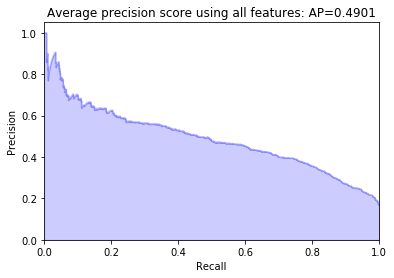

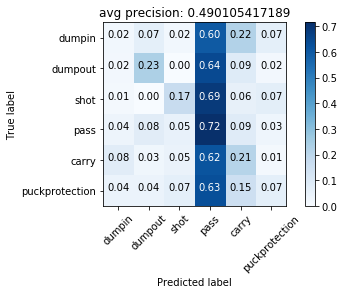

Train: 
Epoch: 74, Loss: 0.00120556208189, Accuracy: 0.993247210804
Validation: 
Epoch: 74, Loss: 0.710208112204, Accuracy: 0.48178613396 , Avg Precision: 0.477193154989
Normalized confusion matrix
[[ 0.08888889  0.04444444  0.04444444  0.46666667  0.33333333  0.02222222]
 [ 0.01785714  0.19642857  0.03571429  0.64285714  0.10714286  0.        ]
 [ 0.05714286  0.          0.21428571  0.62857143  0.05714286  0.04285714]
 [ 0.05154639  0.06804124  0.05979381  0.67216495  0.12371134  0.02474227]
 [ 0.09395973  0.01342282  0.04697987  0.4966443   0.33557047  0.01342282]
 [ 0.08695652  0.04347826  0.06521739  0.52173913  0.19565217  0.08695652]]


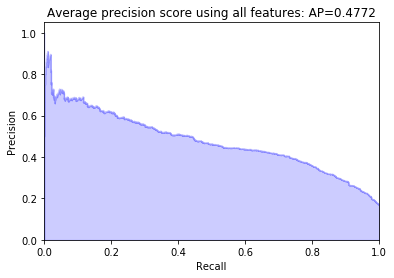

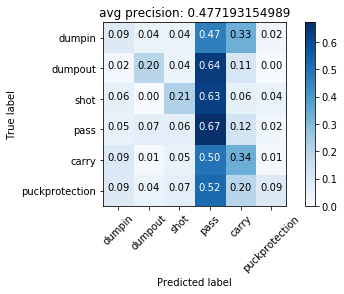

Train: 
Epoch: 75, Loss: 0.000750138475107, Accuracy: 0.995302407516
Validation: 
Epoch: 75, Loss: 0.673902495807, Accuracy: 0.454759106933 , Avg Precision: 0.434630046054
Normalized confusion matrix
[[ 0.02222222  0.11111111  0.          0.46666667  0.33333333  0.06666667]
 [ 0.01785714  0.39285714  0.03571429  0.375       0.16071429  0.01785714]
 [ 0.04285714  0.          0.25714286  0.52857143  0.1         0.07142857]
 [ 0.04948454  0.11752577  0.06185567  0.57525773  0.15257732  0.04329897]
 [ 0.09395973  0.06711409  0.00671141  0.40268456  0.40268456  0.02684564]
 [ 0.06521739  0.06521739  0.06521739  0.36956522  0.2826087   0.15217391]]


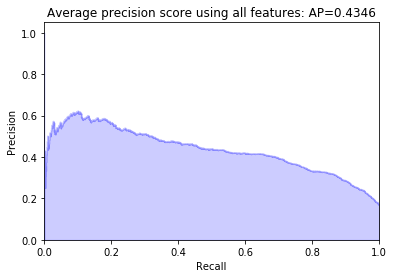

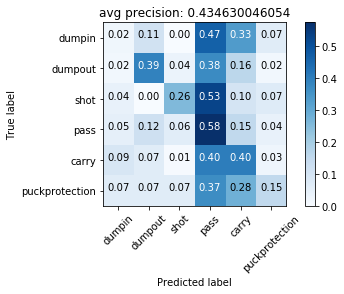

Train: 
Epoch: 76, Loss: 0.00171394108084, Accuracy: 0.989430416911
Validation: 
Epoch: 76, Loss: 0.694952055708, Accuracy: 0.509988249119 , Avg Precision: 0.480849664663
Normalized confusion matrix
[[ 0.02222222  0.08888889  0.          0.51111111  0.26666667  0.11111111]
 [ 0.01785714  0.19642857  0.          0.64285714  0.125       0.01785714]
 [ 0.01428571  0.          0.08571429  0.74285714  0.08571429  0.07142857]
 [ 0.00618557  0.07010309  0.01649485  0.74845361  0.08865979  0.07010309]
 [ 0.04697987  0.02684564  0.00671141  0.57718121  0.31543624  0.02684564]
 [ 0.02173913  0.06521739  0.02173913  0.54347826  0.2173913   0.13043478]]


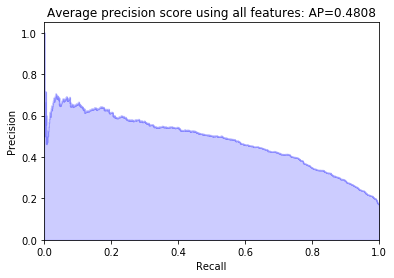

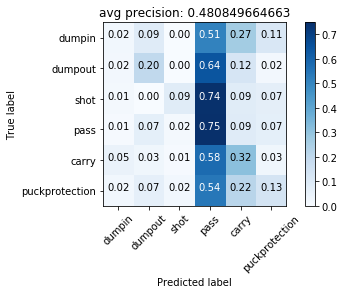

Train: 
Epoch: 77, Loss: 0.00118071916065, Accuracy: 0.992366412214
Validation: 
Epoch: 77, Loss: 0.706874561005, Accuracy: 0.505287896592 , Avg Precision: 0.473781546058
Normalized confusion matrix
[[ 0.06666667  0.08888889  0.          0.51111111  0.24444444  0.08888889]
 [ 0.01785714  0.19642857  0.          0.60714286  0.17857143  0.        ]
 [ 0.01428571  0.          0.15714286  0.61428571  0.11428571  0.1       ]
 [ 0.02268041  0.06391753  0.02680412  0.70309278  0.11546392  0.06804124]
 [ 0.06040268  0.00671141  0.02684564  0.4966443   0.38926174  0.02013423]
 [ 0.02173913  0.          0.02173913  0.52173913  0.30434783  0.13043478]]


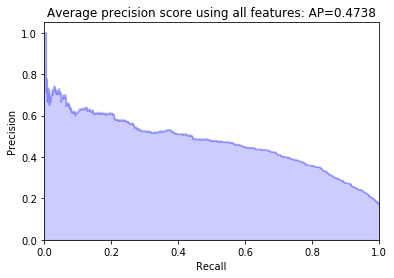

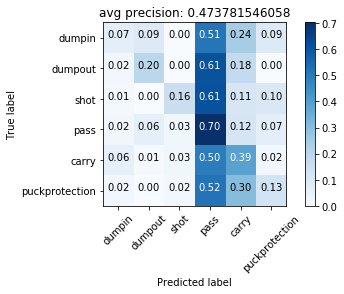

Train: 
Epoch: 78, Loss: 0.000783739016075, Accuracy: 0.993247210804
Validation: 
Epoch: 78, Loss: 0.660128028314, Accuracy: 0.479435957697 , Avg Precision: 0.448203206128
Normalized confusion matrix
[[ 0.04444444  0.08888889  0.02222222  0.37777778  0.44444444  0.02222222]
 [ 0.01785714  0.28571429  0.01785714  0.46428571  0.21428571  0.        ]
 [ 0.01428571  0.          0.34285714  0.52857143  0.08571429  0.02857143]
 [ 0.02474227  0.09072165  0.08659794  0.60412371  0.18350515  0.01030928]
 [ 0.04026846  0.03355705  0.05369128  0.39597315  0.46308725  0.01342282]
 [ 0.02173913  0.06521739  0.13043478  0.52173913  0.17391304  0.08695652]]


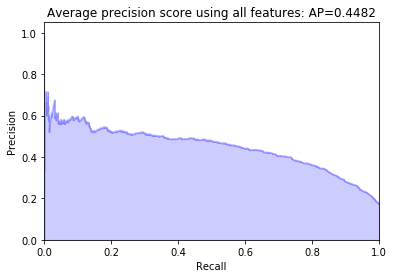

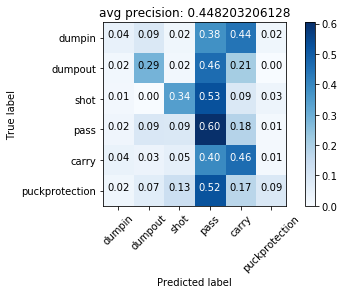

Train: 
Epoch: 79, Loss: 0.0013085874393, Accuracy: 0.993834409865
Validation: 
Epoch: 79, Loss: 0.770164617586, Accuracy: 0.506462984724 , Avg Precision: 0.473203226097
Normalized confusion matrix
[[ 0.02222222  0.08888889  0.          0.35555556  0.48888889  0.04444444]
 [ 0.          0.23214286  0.01785714  0.55357143  0.19642857  0.        ]
 [ 0.01428571  0.          0.11428571  0.72857143  0.1         0.04285714]
 [ 0.02061856  0.09278351  0.02474227  0.68453608  0.15257732  0.02474227]
 [ 0.03355705  0.02684564  0.02684564  0.4295302   0.47651007  0.00671141]
 [ 0.04347826  0.02173913  0.          0.5         0.30434783  0.13043478]]


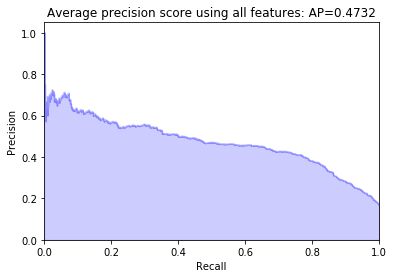

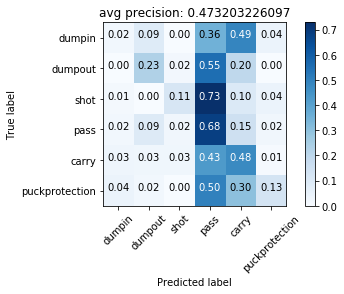

Train: 
Epoch: 80, Loss: 0.00126177907757, Accuracy: 0.991485613623
Validation: 
Epoch: 80, Loss: 0.714258254104, Accuracy: 0.514688601645 , Avg Precision: 0.479576378221
Normalized confusion matrix
[[ 0.06666667  0.06666667  0.02222222  0.51111111  0.28888889  0.04444444]
 [ 0.01785714  0.33928571  0.          0.55357143  0.08928571  0.        ]
 [ 0.01428571  0.          0.25714286  0.64285714  0.07142857  0.01428571]
 [ 0.03505155  0.08865979  0.05979381  0.70309278  0.10309278  0.01030928]
 [ 0.08724832  0.02013423  0.02684564  0.51006711  0.3557047   0.        ]
 [ 0.02173913  0.04347826  0.04347826  0.58695652  0.2173913   0.08695652]]


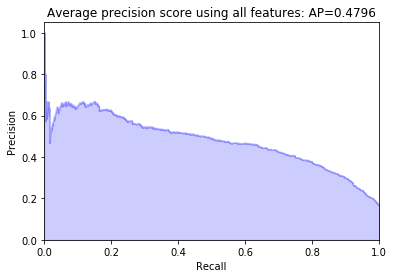

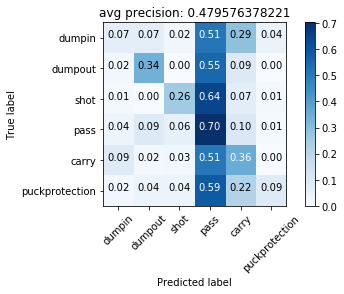

^^^^^^^^^^^^^^^^^^^^^^^^^^
Maximum validation average precision is: 0.502694807058


In [20]:
###########  Initialize all networks and their parameters  ##############
num_classes = 6

#lrs = [1e-1, 1e-2, 1e-3, 1e-4]
hidden_dims = [512]
lrs = [1e-5]
#hidden_dims = [128]
epochs = 80
best_models, all_val_losses, all_val_accs = [], [], []
preds, labels = [], []
pred_scores = []

for lr in lrs:
    for hidden_dim in hidden_dims:
        print '************** Parameters ********************'
        print 'lr: ' + str(lr) + ', hidden_dim: ' + str(hidden_dim)
        print 'Number of training examples: ' + str(len(train_events))
        print 'Number of validation examples: ' + str(len(val_events))
        
        hidden_dim_player=hidden_dim
        hidden_dim_player_coordinate=hidden_dim
        hidden_dim_frame=hidden_dim
        hidden_dim_event=hidden_dim
        
        player_feature_dim = 2048
        rgb_frame_feature_dim = 2048
        input_size_event = hidden_dim_frame + 2*hidden_dim_player + 2*hidden_dim_player_coordinate
        
        coordinate_linear_layer_1 = nn.Linear(2, hidden_dim_player_coordinate//2).cuda()
        coordinate_linear_layer_2 = nn.Linear(hidden_dim_player_coordinate, hidden_dim_player_coordinate//2).cuda()
        rgb_frame_lstm = simple_LSTM(input_size=rgb_frame_feature_dim, hidden_size=hidden_dim_frame, output_size=0).cuda()
        player_lstm = simple_LSTM(input_size=player_feature_dim, hidden_size=hidden_dim_player, output_size=0).cuda()
        coordinate_lstm = simple_LSTM(input_size=hidden_dim_player_coordinate, hidden_size=hidden_dim_player_coordinate, output_size=0).cuda()
        event_lstm = simple_LSTM(input_size=input_size_event, hidden_size=hidden_dim_event, output_size=6).cuda()
        
        all_val_loss, all_val_acc, best_predictions, best_labels, pred_logits= train(train_events=train_events, val_events=val_events, num_classes=num_classes, num_epochs=epochs, print_every=5000,
              rgb_frame_lstm=rgb_frame_lstm, player_lstm=player_lstm, coordinate_lstm=coordinate_lstm, event_lstm=event_lstm, 
              coordinate_linear_layer_1=coordinate_linear_layer_1, coordinate_linear_layer_2=coordinate_linear_layer_2,
              lr_player=lr, lr_coordinate=lr, lr_rgb_frame=lr, lr_event=lr, 
              lr_coordinate_linear_layer_1=lr, lr_coordinate_linear_layer_2=lr, lr_linear_layer=lr, weight=[1, 1, 1, 0.1, 0.3, 1],
              hidden_dim_player=hidden_dim, hidden_dim_frame=hidden_dim, hidden_dim_coordinate=hidden_dim, hidden_dim_event=hidden_dim)
        
            
        #best_models.append([best_rgb_frame_lstm, best_player_lstm, best_coordinate_lstm, best_event_lstm, best_linear_layer, best_coordinate_linear_layer_1, best_coordinate_linear_layer_2])
        all_val_losses.append(all_val_loss)
        all_val_accs.append(all_val_acc)
        preds.append(best_predictions)
        labels.append(best_labels)
        pred_scores.append(pred_logits)

In [18]:
a = []
for i in pred_scores[0]:
    a += np.array(i.data)[0],
a = np.array(a)
print a.shape
b = []
for i in labels[0]:
    b += i[0],
b = np.array(b)
b_binary = label_binarize(b, [0, 1, 2, 3, 4, 5])
print b_binary.shape
print get_ap(b_binary, a, 6, 'all', 'all')

(851, 6)
(851, 6)


IndexError: too many indices for array

Normalized confusion matrix
[[ 0.          0.06666667  0.          0.64444444  0.28888889  0.        ]
 [ 0.          0.16071429  0.          0.78571429  0.05357143  0.        ]
 [ 0.01428571  0.          0.22857143  0.67142857  0.07142857  0.01428571]
 [ 0.00206186  0.05773196  0.05979381  0.78762887  0.07835052  0.01443299]
 [ 0.00671141  0.01342282  0.06040268  0.60402685  0.30872483  0.00671141]
 [ 0.          0.02173913  0.06521739  0.63043478  0.2173913   0.06521739]]


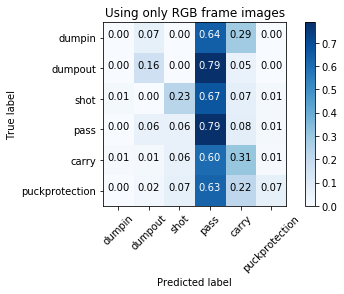

Validation accuracy: 53.58%


In [21]:
for i in range(len(preds)):

    cfm_frame = confusion_matrix(labels[i], preds[i])
    plt.figure()
    plot_confusion_matrix(cfm_frame, classes=['dumpin', 'dumpout', 'shot', 'pass', 'carry', 'puckprotection'], normalize=True,
                          title='Using only RGB frame images')
    plt.savefig('cfm/max_pooling_512.png')
    plt.show()
    #acc_frame = float(np.sum(np.array(labels) == np.array(predictions))) / float(len(predictions))
    print 'Validation accuracy: ' + str('%.2f' % (max(all_val_accs[i])*100)) + '%'

In [ ]:
print len(all_val_accs)
for i in range(len(all_val_accs)):
    print max(all_val_accs[i])

In [ ]:
print (len(best_model))

In [ ]:
hidden_dims = [128, 256]
for i, best_model in enumerate(best_models):

    rgb_frame_lstm = best_model[0]
    player_lstm = best_model[1]
    event_lstm = best_model[2]
    linear_layer = best_model[3]

    hidden_dim = hidden_dims[i]
    hidden_dim_player=hidden_dim
    hidden_dim_frame=hidden_dim
    hidden_dim_event=hidden_dim

    rgb_frame_lstm.eval()
    player_lstm.eval()
    event_lstm.eval()
    linear_layer.eval()
    val_loss, val_correct = 0, 0

    weight=[1, 1, 1, 0.1, 0.3, 1]
    weight = Variable(torch.FloatTensor(np.array(weight))).cuda()
    criterion = nn.MultiMarginLoss(p=2, weight=weight).cuda()

    labels, predictions = [], []
    for count_iter, event in enumerate(val_events):

        correct, loss, logits = step(event_line=event, criterion=criterion,
                             player_lstm=player_lstm, rgb_frame_lstm=rgb_frame_lstm, event_lstm=event_lstm,
                             linear_layer=linear_layer, softmax=softmax,
                             hidden_dim_player=hidden_dim_player, hidden_dim_frame=hidden_dim_frame, hidden_dim_event=hidden_dim_event, 
                             num_classes=num_classes)

        prediction = torch.max(logits, 1)[1].data
        event_name = event.split('_')[1]
        label = np.array([event_to_label[event_name]])
        predictions.append(prediction)
        labels.append(label)

        val_loss += loss.data[0]
        val_correct += correct
    print float(val_correct)/float(len(val_events))

    cfm_frame = confusion_matrix(labels, predictions)
    plt.figure()
    plot_confusion_matrix(cfm_frame, classes=['dumpin', 'dumpout', 'shot', 'pass', 'carry', 'puckprotection'], normalize=True,
                          title='Using only RGB frame images')
    #plt.savefig('cfm/rgb.png')
    plt.show()
    acc_frame = float(np.sum(np.array(labels) == np.array(predictions))) / float(len(predictions))
    print 'Validation accuracy: ' + str('%.2f' % (max(all_val_accs[i])*100)) + '%'

In [ ]:
# cfm_frame = confusion_matrix(labels, predictions)
# plt.figure()
# plot_confusion_matrix(cfm_frame, classes=['dumpin', 'dumpout', 'shot', 'pass'], normalize=True,
#                       title='Using only RGB frame images')
# plt.savefig('cfm/rgb.png')
# plt.show()
# acc_frame = float(np.sum(np.array(frame_labels) == np.array(frame_predictions))) / float(len(frame_predictions))
# print 'Accuracy for using only RGB frame images is: ' + str('%.2f' % (acc_frame*100)) + '%'